# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this projet, I will use _color selection_, _region of interest selection_, _grayscaling_, _Gaussian smoothing_, _Canny Edge Detection_ and _Hough Tranform line detection_ to detect the lane line from the figures of the road. 

### Load packages

In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.linear_model import LinearRegression
import moviepy
import math
%matplotlib inline

### Read the image list

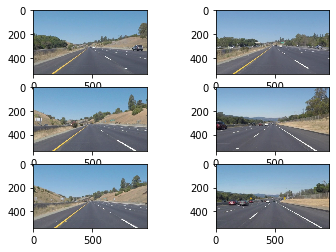

In [2]:
#define the function for image list reading
def img_read(image_dir):
    image_files=[f for f in os.listdir(image_dir) if f[-3:] == 'jpg']
    image_list=[]
    for f in image_files:
        im=mpimg.imread(image_dir + f)
        image_list.append(im)
    return image_list

#read the images in the folder 'test_images' and show them
image_list=img_read('./test_images/')
for i in range(len(image_list)):
    plt.subplot(3,2,i+1)
    plt.imshow(image_list[i])

### Define useful functions

In [3]:
# extract white and yellow colors from the image
def color_extract(img):
    # Yellow color range
    print(img)
    yellow_c1 = img[:,:,0] > 210 #结果为2维,boolean kernel,
    yellow_c2 = img[:,:,1] > 170
    yellow_c3 = img[:,:,1] < 210
    yellow_c4 = img[:,:,2] < 140
    yellow = yellow_c1 & yellow_c2 & yellow_c4 & yellow_c3# yellow为2维kernel;   &:one false-> result=false
    # White color range
    white_c1 = img[:,:,0] > 222
    white_c2 = img[:,:,1] > 222
    white_c3 = img[:,:,2] > 222
    white = white_c1 & white_c1 & white_c1
    
    img_lane = np.zeros_like(img) #和img一样大小的zero kernel
    img_lane[:,:,0]=img[:,:,0] * (yellow | white) 
    img_lane[:,:,1]=img[:,:,1] * (yellow | white)
    img_lane[:,:,2]=img[:,:,2] * (yellow | white)
    return img_lane

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Define the mask
def img_mask(img, region_bottom, region_top, region_height):
    bottom_left = np.array([(img.shape[1]-img.shape[1]*region_bottom)//2, img.shape[0]],dtype = np.int32)
    bottom_right = np.array([(img.shape[1]+img.shape[1]*region_bottom)//2, img.shape[0]],dtype = np.int32)
    top_left = np.array([(img.shape[1]-img.shape[1]*region_top)//2, img.shape[0]*(1-region_height)],dtype = np.int32)
    top_right = np.array([(img.shape[1]+img.shape[1]*region_top)//2, img.shape[0]*(1-region_height)],dtype = np.int32)

    vertices = np.array([[bottom_left, bottom_right, top_right, top_left]], dtype = np.int32)
    img_masked = region_of_interest(img, vertices)
    return img_masked


def draw_lines(img, lines, color=[255, 0, 0], thickness=8): #(lines=[[[x,y,x,y]],[[..]],[[..]]];双括号)
    
    # Set global variebles
    global cache
    global init
    alpha = 0.4
    
    # Calculate slopes and sizes of lanes
    lines = np.squeeze(lines) #降维 [[1 2 3 4][..]]
    slopes = (lines[:,3]-lines[:,1]) / (lines[:,2] - lines[:,0])
    line_size = np.sqrt((lines[:,2] - lines[:,0])**2 + (lines[:,3]-lines[:,1])**2)
    
    # Get rid of outlier lines（斜率小于0.5的线一般为横向线或者其它车道）
    slope_threshold = 0.5
    lines = lines[np.abs(slopes)> slope_threshold]
    line_size = line_size[np.abs(slopes)> slope_threshold]
    slopes = slopes[np.abs(slopes)> slope_threshold]

    # Seperate positive and negative slopes, lines, and sizes
    left_slopes, right_slopes = slopes[slopes>0], slopes[slopes<0]
    left_lines, right_lines = lines[slopes>0,:], lines[slopes<0,:]
    left_length, right_length = line_size[slopes>0], line_size[slopes<0]
    left_num = left_length.shape[0]
    right_num = right_length.shape[0]

    # Prepare to linear regression #
    #!!!!解释： put points from Hough transform together, then use linear regression to merge to a long line
    left_x = np.concatenate([left_lines[:,0], left_lines[:,2]]).reshape(2*left_num)
    left_y = np.concatenate([left_lines[:,1], left_lines[:,3]]).reshape(-1, 1)
    # The weight of each x,y is defined as the length of the correponding line 
    left_weight = np.concatenate([left_length, left_length]).reshape(2*left_num)
    
    right_x = np.concatenate([right_lines[:,0], right_lines[:,2]]).reshape(2*right_num)
    right_y = np.concatenate([right_lines[:,1], right_lines[:,3]]).reshape(-1, 1)
    right_weight = np.concatenate([right_length, right_length]).reshape(2*right_num)    
    
    # Fit the left and right lines using sklearn
    # Switch x and y for the convienience of prediction
    line_left = LinearRegression(fit_intercept=True)
    line_left.fit(left_y, left_x, sample_weight=left_weight)
        # x = my + b
        
    line_right = LinearRegression(fit_intercept=True)
    line_right.fit(right_y, right_x, sample_weight=right_weight)
    
    # Calculate the end points of the left and right line 

    left_point1 = (line_left.predict([[img.shape[0]]]), img.shape[0])##2-d array, 2 sq brakets added
    #正常：放x的值，求y的值；由于上面xy倒着放，则可以求出；img.shape[0]=height=y值，y的最大值在屏幕最下方
    left_point2 = (line_left.predict([[img.shape[0]*0.6]]), int(img.shape[0]*0.6))
    #拿y的0.6来推算；屏幕40%的地方有线
    right_point1 = (line_right.predict([[img.shape[0]]]), img.shape[0])
    right_point2 = (line_right.predict([[img.shape[0]*0.6]]), int(img.shape[0]*0.6))
    
    #curr_frame = np.array([left_point1],[left_point2],[right_point1],[right_point2], dtype='float32')
    curr_frame = np.concatenate([left_point1, left_point2, right_point1])
    curr_frame = np.append(curr_frame, right_point2)
    
    # Judge if it is the first frame and smoothen the detected line
    if init == 1:       
        init = 0        
    else :
        prev_frame = cache
        curr_frame = (1-alpha)*prev_frame + alpha*curr_frame
    
    cache = curr_frame
    
    # Print lines
    cv2.line(img, (int(curr_frame[0]), int(curr_frame[1])), (int(curr_frame[2]),int(curr_frame[3])), color, thickness)
    cv2.line(img, (int(curr_frame[4]), int(curr_frame[5])), (int(curr_frame[6]),int(curr_frame[7])), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)#all zero kernel same size as img
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Define global parameters

In [4]:
# Gaussian smoothing
kernel_size = 5

# Canny Edge Detector
canny_low_threshold = 40
canny_high_threshold = 150

# Region-of-interest vertices of a trapezoid shape
region_bottom = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
region_top = 0.1  # ditto for top edge of trapezoid
region_height = 0.4  # ratio of the height of the trapezoid to the height of the image

# Hough Transform
hough_rho = 2 # distance resolution in pixels of the Hough grid
hough_theta = np.pi/180 # angular resolution in radians of the Hough grid
hough_threshold = 15     # minimum number of votes (intersections in Hough grid cell)
hough_min_line_length = 10 #minimum number of pixels making up a line
hough_max_line_gap = 20    # maximum gap in pixels between connectable line segments

### Define the image processing function

In [5]:
def process_image(img):
    img_lane = color_extract(img)
    img_gray = grayscale(img_lane)
    img_blur = gaussian_blur(img_gray, kernel_size=7)
    img_canny = canny(img_blur, canny_low_threshold, high_threshold=150)
    img_masked = img_mask(img_canny,region_bottom, region_top, region_height)
    img_hough = hough_lines(img_masked, hough_rho, hough_theta, hough_threshold, hough_min_line_length, hough_max_line_gap)
    return weighted_img(img_hough, img)

[[[102 156 202]
  [102 156 202]
  [102 156 202]
  ...
  [ 96 153 196]
  [ 94 151 194]
  [ 88 145 188]]

 [[102 156 200]
  [102 156 200]
  [102 156 200]
  ...
  [ 96 153 196]
  [ 94 151 194]
  [ 88 145 188]]

 [[102 157 198]
  [102 157 198]
  [102 157 198]
  ...
  [ 98 152 196]
  [ 96 150 194]
  [ 90 144 188]]

 ...

 [[ 95 100 106]
  [ 95 100 106]
  [ 95 100 106]
  ...
  [ 73  79  93]
  [ 73  79  93]
  [ 73  79  93]]

 [[ 95 100 106]
  [ 95 100 106]
  [ 95 100 106]
  ...
  [ 71  77  91]
  [ 71  77  91]
  [ 71  77  91]]

 [[ 94  99 105]
  [ 94  99 105]
  [ 94  99 105]
  ...
  [ 73  77  89]
  [ 73  77  89]
  [ 73  77  89]]]
[[[184 196 210]
  [144 159 178]
  [132 154 177]
  ...
  [127 153 176]
  [140 161 178]
  [183 199 214]]

 [[143 158 177]
  [144 162 184]
  [132 156 182]
  ...
  [124 154 180]
  [137 159 180]
  [141 160 177]]

 [[131 153 176]
  [132 156 182]
  [125 154 184]
  ...
  [117 150 181]
  [123 150 177]
  [125 151 174]]

 ...

 [[129 128 134]
  [115 114 120]
  [110 109 115]
  ..

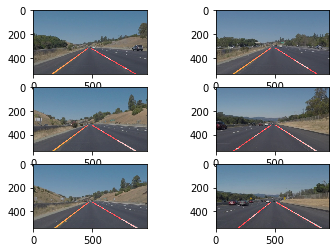

In [6]:
# Try out the function process_image
for i in range(len(image_list)):
    plt.subplot(3,2,i+1)
    init = 1
    plt.imshow(process_image(image_list[i]))

[[[184 196 210]
  [144 159 178]
  [132 154 177]
  ...
  [127 153 176]
  [140 161 178]
  [183 199 214]]

 [[143 158 177]
  [144 162 184]
  [132 156 182]
  ...
  [124 154 180]
  [137 159 180]
  [141 160 177]]

 [[131 153 176]
  [132 156 182]
  [125 154 184]
  ...
  [117 150 181]
  [123 150 177]
  [125 151 174]]

 ...

 [[129 128 134]
  [115 114 120]
  [110 109 115]
  ...
  [ 82  82  92]
  [ 87  87  97]
  [119 119 129]]

 [[141 140 145]
  [125 124 129]
  [115 114 119]
  ...
  [ 88  88  98]
  [106 106 114]
  [136 136 144]]

 [[176 175 180]
  [139 138 143]
  [128 127 132]
  ...
  [119 119 127]
  [137 137 145]
  [183 183 191]]]


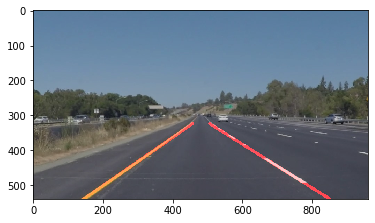

In [7]:
# Sample image
init = 1
plt.imshow(process_image(image_list[1]))

### Process the videos

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
init = 1
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip2.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|▏         | 5/221 [00:00<00:04, 49.05it/s, now=None]

[[[109 162 201]
  [109 162 201]
  [109 162 201]
  ...
  [ 44  42  50]
  [ 41  39  47]
  [ 41  39  47]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ...
  [ 44  42  50]
  [ 41  39  47]
  [ 41  39  47]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ...
  [ 44  42  50]
  [ 43  41  49]
  [ 41  39  47]]

 ...

 [[ 83  83  95]
  [ 83  83  95]
  [ 83  83  95]
  ...
  [ 90  88  96]
  [ 90  88  96]
  [ 88  86  94]]

 [[ 80  85  95]
  [ 80  85  95]
  [ 78  83  93]
  ...
  [ 88  86  96]
  [ 88  86  96]
  [ 86  84  94]]

 [[ 80  85  95]
  [ 80  85  95]
  [ 78  83  93]
  ...
  [ 85  83  93]
  [ 85  83  93]
  [ 82  80  90]]]
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

[[[109 162 201]
  [109 162 201]
  [109 162 201]
  ...
  [ 44  42  50]
  [ 41  39  47]
  [ 41  39  47]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ...
  [ 44  42  50]
  [ 41  39  47]
  [ 41  39  47]]

 [[109 162 201]
  [109 162 201]
 

t:   5%|▌         | 12/221 [00:00<00:05, 38.12it/s, now=None]

[[[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 87  92  88]
  [ 89  95  86]
  [ 89  95  86]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 90  95  91]
  [ 89  95  86]
  [ 86  92  83]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 94 100  91]
  [ 91  95  80]
  [ 85  89  74]]

 ...

 [[ 78  81  92]
  [ 77  80  91]
  [ 78  81  92]
  ...
  [ 86  85  90]
  [ 85  84  89]
  [ 85  84  89]]

 [[ 77  82  92]
  [ 76  81  91]
  [ 77  82  92]
  ...
  [ 86  84  92]
  [ 86  84  92]
  [ 86  84  92]]

 [[ 75  80  90]
  [ 75  80  90]
  [ 75  80  90]
  ...
  [ 81  79  87]
  [ 81  79  87]
  [ 81  79  87]]]
[[[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [ 92  98 101]
  [ 88  95  93]
  [ 83  90  88]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [ 89  95  98]
  [ 88  95  93]
  [ 85  92  90]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [ 90  97  95]
  [ 87  93  82]
  [ 83  89  78]]

 ...

 [[ 78  81  92]
  [ 77  80  91]
  [ 78  81  92]
  ..

t:  10%|▉         | 21/221 [00:00<00:05, 37.91it/s, now=None]

[[[114 159 201]
  [114 159 201]
  [114 159 201]
  ...
  [112 154 190]
  [115 154 191]
  [108 147 184]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ...
  [113 155 191]
  [117 156 193]
  [110 149 186]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [116 158 194]
  [119 158 195]
  [110 149 186]]

 ...

 [[ 78  81  92]
  [ 78  81  92]
  [ 78  81  92]
  ...
  [ 87  88  93]
  [ 87  88  93]
  [ 83  84  89]]

 [[ 78  81  92]
  [ 78  81  92]
  [ 78  81  92]
  ...
  [ 83  87  89]
  [ 83  87  89]
  [ 78  82  84]]

 [[ 75  78  89]
  [ 75  78  89]
  [ 75  78  89]
  ...
  [ 82  86  88]
  [ 82  86  88]
  [ 77  81  83]]]
[[[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [115 158 201]
  [116 157 200]
  [106 147 190]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [115 158 201]
  [116 157 200]
  [106 147 190]]

 [[112 162 202]
  [112 162 202]
  [112 162 202]
  ...
  [115 158 199]
  [115 158 199]
  [106 149 190]]

 ...

 [[ 78  81  92]
  [ 78  81  92]
  [ 78  81  92]
  ..

t:  11%|█▏        | 25/221 [00:00<00:05, 37.92it/s, now=None]

[[[111 161 199]
  [111 161 199]
  [112 160 199]
  ...
  [114 157 198]
  [110 153 194]
  [108 151 192]]

 [[111 161 199]
  [111 161 199]
  [112 160 199]
  ...
  [113 156 197]
  [110 153 194]
  [108 151 192]]

 [[111 161 199]
  [111 161 199]
  [112 160 199]
  ...
  [113 156 197]
  [110 153 194]
  [108 151 192]]

 ...

 [[ 79  82  91]
  [ 82  85  94]
  [ 79  82  91]
  ...
  [ 85  86  91]
  [ 85  86  91]
  [ 85  86  91]]

 [[ 81  84  93]
  [ 79  82  91]
  [ 81  84  93]
  ...
  [ 84  88  90]
  [ 84  88  90]
  [ 84  88  90]]

 [[ 77  80  89]
  [ 76  79  88]
  [ 76  79  88]
  ...
  [ 81  85  87]
  [ 81  85  87]
  [ 81  85  87]]]
[[[112 160 199]
  [112 160 199]
  [114 159 199]
  ...
  [113 154 193]
  [111 154 195]
  [111 154 195]]

 [[112 160 199]
  [112 160 199]
  [114 159 199]
  ...
  [113 154 193]
  [111 154 195]
  [111 154 195]]

 [[112 160 199]
  [112 160 199]
  [114 159 199]
  ...
  [115 153 193]
  [111 154 195]
  [111 154 195]]

 ...

 [[ 83  83  93]
  [ 83  83  93]
  [ 81  81  91]
  ..

t:  15%|█▍        | 33/221 [00:00<00:05, 31.60it/s, now=None]

[[[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 99 109 125]
  [105 118 135]
  [102 115 132]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [104 114 130]
  [107 120 137]
  [107 120 137]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [105 118 137]
  [105 119 140]
  [110 124 145]]

 ...

 [[ 81  81  93]
  [ 81  81  93]
  [ 83  83  95]
  ...
  [ 83  83  91]
  [ 83  83  91]
  [ 83  83  91]]

 [[ 83  83  95]
  [ 83  83  95]
  [ 83  83  95]
  ...
  [ 81  85  89]
  [ 81  85  89]
  [ 81  85  89]]

 [[ 79  79  91]
  [ 79  79  91]
  [ 79  79  91]
  ...
  [ 78  82  86]
  [ 79  83  87]
  [ 79  83  87]]]
[[[112 160 201]
  [112 160 201]
  [114 159 201]
  ...
  [111 121 137]
  [108 118 136]
  [108 118 136]]

 [[112 160 201]
  [112 160 201]
  [114 159 201]
  ...
  [115 125 141]
  [113 123 141]
  [113 123 141]]

 [[112 160 201]
  [112 160 201]
  [114 159 201]
  ...
  [111 124 143]
  [109 123 144]
  [111 125 146]]

 ...

 [[ 81  81  93]
  [ 81  81  93]
  [ 83  83  95]
  ..

t:  19%|█▉        | 42/221 [00:01<00:05, 33.71it/s, now=None]

[[[118 159 202]
  [118 159 202]
  [118 159 202]
  ...
  [102 117 133]
  [ 95 108 123]
  [ 90 103 118]]

 [[118 159 202]
  [118 159 202]
  [118 159 202]
  ...
  [104 119 135]
  [ 97 110 125]
  [ 89 102 117]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ...
  [102 113 124]
  [ 96 106 114]
  [ 89  99 107]]

 ...

 [[ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]
  ...
  [ 93  91  99]
  [ 91  89  97]
  [ 91  89  97]]

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ...
  [ 89  90  95]
  [ 89  90  95]
  [ 89  90  95]]

 [[ 80  80  90]
  [ 80  80  90]
  [ 80  80  90]
  ...
  [ 89  90  95]
  [ 89  90  95]
  [ 89  90  95]]]
[[[118 159 202]
  [118 159 202]
  [118 159 202]
  ...
  [113 128 142]
  [114 128 140]
  [110 124 136]]

 [[118 159 202]
  [118 159 202]
  [118 159 202]
  ...
  [106 121 135]
  [107 121 133]
  [102 116 128]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ...
  [ 97 111 121]
  [ 97 109 117]
  [ 93 105 113]]

 ...

 [[ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]
  ..

t:  21%|██        | 46/221 [00:01<00:06, 28.27it/s, now=None]

[[[115 159 204]
  [115 159 204]
  [115 159 204]
  ...
  [ 86  80  73]
  [ 95  89  82]
  [109 103  96]]

 [[115 159 204]
  [115 159 204]
  [115 159 204]
  ...
  [ 89  83  76]
  [102  96  89]
  [109 103  96]]

 [[112 161 204]
  [112 161 204]
  [112 161 204]
  ...
  [ 94  89  86]
  [104  99  96]
  [101  96  93]]

 ...

 [[ 81  84  93]
  [ 81  84  93]
  [ 81  84  93]
  ...
  [ 92  93  98]
  [ 91  92  97]
  [ 86  87  92]]

 [[ 79  82  91]
  [ 79  82  91]
  [ 79  82  91]
  ...
  [ 90  94  98]
  [ 89  93  97]
  [ 83  87  91]]

 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ...
  [ 84  88  92]
  [ 83  87  91]
  [ 77  81  85]]]
[[[116 159 202]
  [116 159 202]
  [116 159 202]
  ...
  [104 100  92]
  [ 94  88  83]
  [ 85  79  74]]

 [[116 159 202]
  [116 159 202]
  [116 159 202]
  ...
  [103  99  91]
  [100  94  89]
  [ 93  87  82]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [102 101  94]
  [105 103  99]
  [101  99  95]]

 ...

 [[ 78  81  90]
  [ 78  81  90]
  [ 78  81  90]
  ..

t:  24%|██▎       | 52/221 [00:01<00:07, 22.06it/s, now=None]

[[[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [ 80  80  77]
  [ 86  85  88]
  [ 91  90  93]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [ 76  76  73]
  [ 85  84  87]
  [ 91  90  93]]

 [[112 162 202]
  [112 162 202]
  [112 162 202]
  ...
  [ 74  74  71]
  [ 82  81  84]
  [ 89  88  91]]

 ...

 [[ 80  80  90]
  [ 80  80  90]
  [ 80  80  90]
  ...
  [ 91  90  95]
  [ 91  90  95]
  [ 91  90  95]]

 [[ 80  80  90]
  [ 80  80  90]
  [ 80  80  90]
  ...
  [ 89  90  95]
  [ 89  90  95]
  [ 89  90  95]]

 [[ 78  78  88]
  [ 78  78  88]
  [ 78  78  88]
  ...
  [ 84  85  90]
  [ 84  85  90]
  [ 84  85  90]]]
[[[112 162 202]
  [112 162 202]
  [112 162 202]
  ...
  [ 90  89  80]
  [ 84  82  78]
  [ 79  77  73]]

 [[112 162 202]
  [112 162 202]
  [112 162 202]
  ...
  [ 89  88  79]
  [ 86  84  80]
  [ 80  78  74]]

 [[110 163 202]
  [110 163 202]
  [110 163 202]
  ...
  [ 89  88  79]
  [ 87  85  81]
  [ 83  81  77]]

 ...

 [[ 80  80  90]
  [ 80  80  90]
  [ 81  81  91]
  ..

t:  25%|██▍       | 55/221 [00:01<00:08, 20.05it/s, now=None]

[[[115 163 204]
  [114 162 203]
  [112 160 201]
  ...
  [ 90  86  69]
  [ 84  80  63]
  [ 83  79  62]]

 [[115 163 204]
  [114 162 203]
  [112 160 201]
  ...
  [ 89  85  68]
  [ 86  82  65]
  [ 86  82  65]]

 [[115 163 204]
  [114 162 203]
  [112 160 201]
  ...
  [ 97  92  78]
  [ 97  92  78]
  [ 93  88  74]]

 ...

 [[ 79  82  91]
  [ 79  82  91]
  [ 79  82  91]
  ...
  [ 88  86  94]
  [ 88  86  94]
  [ 88  86  94]]

 [[ 79  82  91]
  [ 79  82  91]
  [ 79  82  91]
  ...
  [ 85  86  91]
  [ 85  86  91]
  [ 85  86  91]]

 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ...
  [ 81  82  87]
  [ 81  82  87]
  [ 81  82  87]]]
[[[115 163 204]
  [114 162 203]
  [112 160 201]
  ...
  [ 95  89  80]
  [ 99  94  82]
  [102  97  85]]

 [[115 163 204]
  [114 162 203]
  [112 160 201]
  ...
  [ 92  86  77]
  [ 98  93  81]
  [101  96  84]]

 [[115 163 204]
  [114 162 203]
  [112 160 201]
  ...
  [ 89  85  77]
  [ 94  89  77]
  [ 97  92  80]]

 ...

 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ..

t:  26%|██▌       | 58/221 [00:02<00:09, 18.01it/s, now=None]

[[[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [ 90  94  98]
  [ 94  95 100]
  [ 95  96 101]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [ 94  98 102]
  [ 95  96 101]
  [ 96  97 102]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [ 99 104 112]
  [ 93  96 105]
  [ 89  92 101]]

 ...

 [[ 77  80  89]
  [ 78  81  90]
  [ 78  81  90]
  ...
  [ 90  89  92]
  [ 88  87  90]
  [ 87  86  89]]

 [[ 77  80  89]
  [ 78  81  90]
  [ 78  81  90]
  ...
  [ 89  91  91]
  [ 87  89  89]
  [ 86  88  88]]

 [[ 75  78  87]
  [ 76  79  88]
  [ 76  79  88]
  ...
  [ 85  87  87]
  [ 83  85  85]
  [ 81  83  83]]]
[[[114 159 201]
  [114 159 201]
  [115 160 202]
  ...
  [ 92 102 110]
  [ 80  88  97]
  [ 76  84  93]]

 [[114 159 201]
  [114 159 201]
  [115 160 202]
  ...
  [ 86  96 104]
  [ 76  84  93]
  [ 78  86  95]]

 [[114 159 201]
  [114 159 201]
  [115 160 202]
  ...
  [ 79  90 101]
  [ 73  83  91]
  [ 75  85  93]]

 ...

 [[ 77  80  89]
  [ 78  81  90]
  [ 78  81  90]
  ..

t:  28%|██▊       | 62/221 [00:02<00:09, 17.04it/s, now=None]

[[[111 160 203]
  [111 160 203]
  [111 160 203]
  ...
  [ 74  81  76]
  [ 69  78  78]
  [ 74  83  83]]

 [[111 160 203]
  [111 160 203]
  [111 160 203]
  ...
  [ 70  77  72]
  [ 69  78  78]
  [ 73  82  82]]

 [[111 160 203]
  [111 160 203]
  [111 160 203]
  ...
  [ 72  77  71]
  [ 71  77  78]
  [ 73  79  80]]

 ...

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ...
  [ 84  85  90]
  [ 81  82  87]
  [ 81  82  87]]

 [[ 81  81  91]
  [ 81  81  91]
  [ 80  80  90]
  ...
  [ 82  86  90]
  [ 79  83  87]
  [ 79  83  87]]

 [[ 76  76  86]
  [ 76  76  86]
  [ 77  77  87]
  ...
  [ 78  82  86]
  [ 76  80  84]
  [ 76  80  84]]]
[[[114 159 201]
  [114 159 201]
  [114 159 201]
  ...
  [ 83  82  71]
  [ 83  82  71]
  [ 83  82  71]]

 [[114 159 201]
  [114 159 201]
  [114 159 201]
  ...
  [ 84  83  72]
  [ 84  83  72]
  [ 84  83  72]]

 [[114 159 201]
  [114 159 201]
  [114 159 201]
  ...
  [ 87  86  75]
  [ 87  86  75]
  [ 87  86  75]]

 ...

 [[ 89  93  97]
  [ 89  93  97]
  [ 87  91  95]
  ..

t:  31%|███       | 68/221 [00:02<00:08, 17.45it/s, now=None]

[[[109 162 201]
  [109 162 201]
  [109 162 201]
  ...
  [ 96  95  84]
  [ 91  90  79]
  [ 83  82  71]]

 [[109 162 201]
  [109 162 201]
  [109 162 201]
  ...
  [ 97  96  85]
  [ 92  91  80]
  [ 84  83  72]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 99  98  91]
  [ 95  94  85]
  [ 87  86  77]]

 ...

 [[ 79  82  91]
  [ 81  84  93]
  [ 85  85  95]
  ...
  [ 89  88  93]
  [ 87  86  91]
  [ 85  84  89]]

 [[ 81  84  93]
  [ 81  84  93]
  [ 86  86  96]
  ...
  [ 88  86  94]
  [ 85  83  91]
  [ 83  81  89]]

 [[ 76  79  88]
  [ 77  80  89]
  [ 83  83  93]
  ...
  [ 85  83  91]
  [ 81  79  87]
  [ 80  78  86]]]
[[[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [109 109 106]
  [104 100  94]
  [ 99  95  89]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [109 109 106]
  [106 102  96]
  [100  96  90]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [108 109 114]
  [109 107 108]
  [105 103 104]]

 ...

 [[ 81  84  93]
  [ 81  84  93]
  [ 85  85  95]
  ..

t:  32%|███▏      | 70/221 [00:02<00:09, 16.29it/s, now=None]

[[[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [108 117 117]
  [ 93 103 109]
  [ 80  90  96]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [ 98 107 107]
  [ 87  97 103]
  [ 79  89  95]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ...
  [ 95 102 100]
  [ 89  98 100]
  [ 81  90  92]]

 ...

 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ...
  [ 89  88  93]
  [ 89  88  93]
  [ 88  87  92]]

 [[ 78  81  88]
  [ 77  80  87]
  [ 77  80  89]
  ...
  [ 89  87  95]
  [ 89  87  95]
  [ 88  86  94]]

 [[ 76  79  86]
  [ 77  80  87]
  [ 77  80  89]
  ...
  [ 87  85  93]
  [ 86  84  92]
  [ 86  84  92]]]
[[[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [ 98 101  79]
  [ 92  96  81]
  [ 91  95  80]]

 [[113 161 202]
  [113 161 202]
  [113 161 202]
  ...
  [101 104  82]
  [ 96 100  85]
  [ 95  99  84]]

 [[115 160 202]
  [115 160 202]
  [115 160 202]
  ...
  [100 103  79]
  [ 98 101  81]
  [ 98 101  81]]

 ...

 [[ 77  80  89]
  [ 78  81  90]
  [ 82  85  94]
  ..

t:  34%|███▍      | 76/221 [00:03<00:07, 19.78it/s, now=None]

[[[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 98  98  66]
  [ 99  99  69]
  [100 100  70]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 98  98  66]
  [ 98  98  68]
  [100 100  70]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [ 94  94  64]
  [ 94  93  66]
  [ 96  95  68]]

 ...

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ...
  [ 88  86  94]
  [ 88  86  94]
  [ 88  86  94]]

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ...
  [ 87  87  95]
  [ 87  87  95]
  [ 87  87  95]]

 [[ 78  81  90]
  [ 78  81  90]
  [ 78  81  90]
  ...
  [ 83  83  91]
  [ 83  83  91]
  [ 83  83  91]]]
[[[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 88  91  56]
  [ 92  92  60]
  [ 94  94  62]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [ 83  86  51]
  [ 90  90  58]
  [ 92  92  60]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [ 84  87  54]
  [ 89  89  59]
  [ 91  91  61]]

 ...

 [[ 79  82  91]
  [ 78  81  90]
  [ 78  81  90]
  ..

t:  37%|███▋      | 82/221 [00:03<00:07, 19.48it/s, now=None]

[[[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [ 89  90  69]
  [ 90  91  70]
  [ 89  90  69]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [ 90  91  70]
  [ 89  90  69]
  [ 88  89  68]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [ 88  89  68]
  [ 86  87  68]
  [ 84  85  66]]

 ...

 [[ 80  80  90]
  [ 80  80  90]
  [ 80  80  90]
  ...
  [ 88  86  94]
  [ 85  83  91]
  [ 82  80  88]]

 [[ 80  80  90]
  [ 80  80  90]
  [ 80  80  90]
  ...
  [ 88  88  96]
  [ 85  85  93]
  [ 84  84  92]]

 [[ 77  77  87]
  [ 77  77  87]
  [ 77  77  87]
  ...
  [ 86  86  94]
  [ 83  83  91]
  [ 80  80  88]]]
[[[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [104 103  78]
  [ 99  98  71]
  [ 93  92  65]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [104 103  78]
  [ 98  97  70]
  [ 92  91  64]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [103 102  77]
  [ 98  97  72]
  [ 93  92  67]]

 ...

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ..

t:  38%|███▊      | 85/221 [00:03<00:07, 18.85it/s, now=None]

[[[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [114 158 194]
  [114 158 192]
  [106 150 184]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [114 158 194]
  [114 158 192]
  [106 150 184]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [114 158 194]
  [115 159 193]
  [107 151 185]]

 ...

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ...
  [ 91  89  97]
  [ 87  85  93]
  [ 85  83  91]]

 [[ 81  81  91]
  [ 81  81  91]
  [ 83  83  93]
  ...
  [ 86  86  94]
  [ 85  85  93]
  [ 84  84  92]]

 [[ 77  77  87]
  [ 78  78  88]
  [ 79  79  89]
  ...
  [ 83  83  91]
  [ 81  81  89]
  [ 83  83  91]]]
[[[114 159 201]
  [114 159 201]
  [114 159 201]
  ...
  [115 158 197]
  [115 159 195]
  [107 151 187]]

 [[114 159 201]
  [114 159 201]
  [114 159 201]
  ...
  [115 158 197]
  [116 160 196]
  [108 152 188]]

 [[114 159 201]
  [114 159 201]
  [114 159 201]
  ...
  [115 158 197]
  [116 159 198]
  [108 151 190]]

 ...

 [[ 81  81  91]
  [ 83  83  93]
  [ 83  83  93]
  ..

t:  41%|████      | 91/221 [00:03<00:06, 21.43it/s, now=None]

[[[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [110 158 195]
  [111 159 196]
  [103 151 188]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [111 159 196]
  [112 160 197]
  [103 151 188]]

 [[112 160 201]
  [112 160 201]
  [112 160 201]
  ...
  [110 158 197]
  [111 159 196]
  [104 152 189]]

 ...

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ...
  [ 89  87  95]
  [ 89  87  95]
  [ 88  86  94]]

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ...
  [ 87  87  95]
  [ 87  87  95]
  [ 87  87  95]]

 [[ 79  79  89]
  [ 79  79  89]
  [ 79  79  89]
  ...
  [ 85  85  93]
  [ 86  86  94]
  [ 86  86  94]]]
[[[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [113 158 198]
  [112 157 197]
  [102 147 187]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [114 159 199]
  [113 158 198]
  [102 147 187]]

 [[111 161 201]
  [111 161 201]
  [111 161 201]
  ...
  [113 158 200]
  [112 157 197]
  [103 148 188]]

 ...

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ..

t:  44%|████▍     | 97/221 [00:04<00:05, 22.64it/s, now=None]

[[[107 160 199]
  [107 160 199]
  [107 160 199]
  ...
  [112 160 201]
  [111 159 200]
  [103 151 192]]

 [[107 160 199]
  [107 160 199]
  [107 160 199]
  ...
  [112 160 201]
  [110 158 199]
  [103 151 192]]

 [[107 160 199]
  [107 160 199]
  [107 160 199]
  ...
  [111 159 200]
  [110 158 199]
  [101 149 190]]

 ...

 [[ 81  84  93]
  [ 81  84  93]
  [ 82  85  94]
  ...
  [ 89  87  95]
  [ 89  87  95]
  [ 89  87  95]]

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ...
  [ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]]

 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ...
  [ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]]]
[[[107 159 201]
  [107 159 201]
  [107 159 201]
  ...
  [112 160 201]
  [111 159 200]
  [103 151 192]]

 [[107 159 201]
  [107 159 201]
  [107 159 201]
  ...
  [112 160 201]
  [110 158 199]
  [103 151 192]]

 [[107 159 201]
  [107 159 201]
  [107 159 201]
  ...
  [111 159 200]
  [110 158 199]
  [101 149 190]]

 ...

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ..

t:  45%|████▌     | 100/221 [00:04<00:05, 23.19it/s, now=None]

[[[113 157 202]
  [113 157 202]
  [113 157 202]
  ...
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 [[113 157 202]
  [113 157 202]
  [113 157 202]
  ...
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 [[113 157 202]
  [113 157 202]
  [113 157 202]
  ...
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 ...

 [[ 85  88  97]
  [ 84  87  96]
  [ 84  87  96]
  ...
  [ 89  87  95]
  [ 86  84  92]
  [ 83  81  89]]

 [[ 83  86  95]
  [ 82  85  94]
  [ 82  85  94]
  ...
  [ 89  87  95]
  [ 86  84  92]
  [ 85  83  91]]

 [[ 77  80  89]
  [ 77  80  89]
  [ 77  80  89]
  ...
  [ 83  81  89]
  [ 81  79  87]
  [ 80  78  86]]]
[[[113 157 202]
  [113 157 202]
  [113 157 202]
  ...
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 [[113 157 202]
  [113 157 202]
  [113 157 202]
  ...
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 [[113 157 202]
  [113 157 202]
  [113 157 202]
  ...
  [113 158 200]
  [112 157 199]
  [103 148 190]]

 ...

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ..

t:  48%|████▊     | 106/221 [00:04<00:04, 23.13it/s, now=None]

[[[112 157 197]
  [112 157 197]
  [112 157 197]
  ...
  [113 156 197]
  [111 154 195]
  [103 146 187]]

 [[112 157 197]
  [112 157 197]
  [112 157 197]
  ...
  [113 156 197]
  [111 154 195]
  [103 146 187]]

 [[112 157 197]
  [112 157 197]
  [112 157 197]
  ...
  [113 156 197]
  [111 154 195]
  [103 146 187]]

 ...

 [[ 81  81  93]
  [ 81  81  93]
  [ 81  81  91]
  ...
  [ 90  89  92]
  [ 88  87  90]
  [ 85  84  87]]

 [[ 79  82  91]
  [ 79  82  91]
  [ 79  82  91]
  ...
  [ 90  89  94]
  [ 87  86  91]
  [ 82  81  86]]

 [[ 76  79  88]
  [ 76  79  88]
  [ 76  79  88]
  ...
  [ 89  88  93]
  [ 86  85  90]
  [ 81  80  85]]]
[[[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [113 156 197]
  [111 154 195]
  [103 146 187]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [113 156 197]
  [111 154 195]
  [103 146 187]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [113 156 197]
  [111 154 195]
  [103 146 187]]

 ...

 [[ 81  81  93]
  [ 81  81  93]
  [ 81  81  91]
  ..

t:  51%|█████     | 112/221 [00:04<00:04, 21.85it/s, now=None]

[[[108 156 197]
  [108 156 197]
  [110 158 199]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[108 156 197]
  [108 156 197]
  [110 158 199]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[108 156 197]
  [108 156 197]
  [110 158 199]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ...
  [ 86  87  92]
  [ 86  87  92]
  [ 86  87  92]]

 [[ 79  82  89]
  [ 79  82  89]
  [ 79  82  89]
  ...
  [ 85  86  91]
  [ 85  86  91]
  [ 85  86  91]]

 [[ 76  79  86]
  [ 76  79  86]
  [ 76  79  86]
  ...
  [ 81  82  87]
  [ 80  81  86]
  [ 80  81  86]]]
[[[110 158 199]
  [110 158 199]
  [111 159 200]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[110 158 199]
  [110 158 199]
  [111 159 200]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[110 158 199]
  [110 158 199]
  [111 159 200]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ..

t:  52%|█████▏    | 115/221 [00:04<00:04, 21.58it/s, now=None]

[[[113 158 200]
  [112 157 199]
  [112 157 199]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[113 158 200]
  [112 157 199]
  [112 157 199]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[113 158 200]
  [112 157 199]
  [112 157 199]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 84  84  94]
  [ 84  84  94]
  [ 85  85  95]
  ...
  [ 87  88  93]
  [ 87  88  93]
  [ 87  88  93]]

 [[ 82  85  92]
  [ 83  86  93]
  [ 84  87  94]
  ...
  [ 86  87  92]
  [ 86  87  92]
  [ 86  87  92]]

 [[ 77  80  87]
  [ 78  81  88]
  [ 78  81  88]
  ...
  [ 85  86  91]
  [ 85  86  91]
  [ 85  86  91]]]
[[[113 158 198]
  [112 157 197]
  [112 157 197]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [112 157 197]
  [112 157 197]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [112 157 197]
  [112 157 197]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 83  83  93]
  [ 84  84  94]
  [ 85  85  95]
  ..

t:  56%|█████▌    | 123/221 [00:05<00:03, 25.08it/s, now=None]

[[[113 156 199]
  [113 156 199]
  [113 156 199]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[113 156 199]
  [113 156 199]
  [113 156 199]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[113 156 199]
  [113 156 199]
  [113 156 199]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 87  87  97]
  [ 87  87  97]
  [ 87  87  97]
  ...
  [ 86  87  92]
  [ 85  86  91]
  [ 84  85  90]]

 [[ 85  88  95]
  [ 85  88  95]
  [ 85  88  95]
  ...
  [ 85  86  91]
  [ 85  86  91]
  [ 83  84  89]]

 [[ 79  82  89]
  [ 79  82  89]
  [ 79  82  89]
  ...
  [ 81  82  87]
  [ 81  82  87]
  [ 79  80  85]]]
[[[113 156 199]
  [113 156 199]
  [113 156 199]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[113 156 199]
  [113 156 199]
  [113 156 199]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[113 156 199]
  [113 156 199]
  [113 156 199]
  ...
  [111 154 195]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 87  87  97]
  [ 87  87  97]
  [ 87  87  97]
  ..

t:  58%|█████▊    | 129/221 [00:05<00:03, 24.39it/s, now=None]

[[[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 ...

 [[ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]
  ...
  [ 87  86  91]
  [ 87  86  91]
  [ 87  86  91]]

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ...
  [ 87  86  91]
  [ 87  86  91]
  [ 87  86  91]]

 [[ 79  82  91]
  [ 79  82  91]
  [ 79  82  91]
  ...
  [ 83  82  87]
  [ 83  82  87]
  [ 83  82  87]]]
[[[114 157 198]
  [114 157 198]
  [113 158 200]
  ...
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 [[114 157 198]
  [114 157 198]
  [113 158 200]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[114 157 198]
  [114 157 198]
  [113 158 200]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 ...

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ..

t:  61%|██████    | 135/221 [00:05<00:03, 23.87it/s, now=None]

[[[111 159 200]
  [111 159 200]
  [111 159 200]
  ...
  [112 157 197]
  [110 155 195]
  [103 148 188]]

 [[111 159 200]
  [111 159 200]
  [111 159 200]
  ...
  [112 157 197]
  [110 155 195]
  [103 148 188]]

 [[111 159 200]
  [111 159 200]
  [111 159 200]
  ...
  [112 157 197]
  [110 155 195]
  [103 148 188]]

 ...

 [[ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]
  ...
  [ 87  85  93]
  [ 87  85  93]
  [ 86  84  92]]

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ...
  [ 86  85  90]
  [ 86  85  90]
  [ 86  85  90]]

 [[ 79  82  91]
  [ 79  82  91]
  [ 79  82  91]
  ...
  [ 85  84  89]
  [ 85  84  89]
  [ 85  84  89]]]
[[[113 158 200]
  [113 158 200]
  [113 158 200]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[113 158 200]
  [113 158 200]
  [113 158 200]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[113 158 200]
  [113 158 200]
  [113 158 200]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 83  86  95]
  [ 83  86  95]
  [ 82  85  94]
  ..

t:  62%|██████▏   | 138/221 [00:05<00:03, 23.59it/s, now=None]

[[[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [117 158 199]
  [116 157 198]
  [109 150 191]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [117 158 199]
  [116 157 198]
  [109 150 191]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [118 159 200]
  [117 158 199]
  [110 151 192]]

 ...

 [[ 84  87  96]
  [ 84  87  96]
  [ 84  87  96]
  ...
  [ 87  85  93]
  [ 86  84  92]
  [ 82  80  88]]

 [[ 84  87  96]
  [ 85  88  97]
  [ 85  88  97]
  ...
  [ 87  86  89]
  [ 86  85  88]
  [ 86  85  88]]

 [[ 82  85  94]
  [ 83  86  95]
  [ 83  86  95]
  ...
  [ 81  80  83]
  [ 81  80  83]
  [ 81  80  83]]]
[[[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 ...

 [[ 90  93 102]
  [ 90  93 102]
  [ 90  93 102]
  ..

t:  65%|██████▌   | 144/221 [00:06<00:03, 25.06it/s, now=None]

[[[114 157 198]
  [114 157 198]
  [114 157 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[114 157 198]
  [114 157 198]
  [114 157 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[114 157 198]
  [114 157 198]
  [114 157 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]
  ...
  [ 89  87  95]
  [ 86  84  92]
  [ 86  84  92]]

 [[ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]
  ...
  [ 89  88  91]
  [ 85  84  87]
  [ 85  84  87]]

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ...
  [ 82  81  84]
  [ 78  77  80]
  [ 78  77  80]]]
[[[114 157 198]
  [114 157 198]
  [114 157 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[114 157 198]
  [114 157 198]
  [114 157 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[114 157 198]
  [114 157 198]
  [114 157 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 ...

 [[ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]
  ..

t:  68%|██████▊   | 150/221 [00:06<00:02, 24.14it/s, now=None]

[[[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [113 156 195]
  [111 154 193]
  [104 147 186]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [114 157 196]
  [113 156 195]
  [106 149 188]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [114 157 196]
  [113 156 195]
  [106 149 188]]

 ...

 [[ 86  86  94]
  [ 86  86  94]
  [ 86  86  94]
  ...
  [ 86  84  94]
  [ 85  83  93]
  [ 82  80  90]]

 [[ 85  88  95]
  [ 85  88  95]
  [ 84  87  94]
  ...
  [ 86  85  88]
  [ 83  82  85]
  [ 81  80  83]]

 [[ 82  85  92]
  [ 81  84  91]
  [ 81  84  91]
  ...
  [ 81  80  83]
  [ 79  78  81]
  [ 76  75  78]]]
[[[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [113 156 197]
  [111 154 195]
  [104 147 188]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [114 157 198]
  [113 156 197]
  [106 149 190]]

 ...

 [[ 89  89  97]
  [ 89  89  97]
  [ 89  89  97]
  ..

t:  71%|███████   | 157/221 [00:06<00:02, 25.48it/s, now=None]

[[[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [113 156 195]
  [113 156 195]
  [107 150 189]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [113 156 195]
  [113 156 195]
  [107 150 189]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [113 156 195]
  [113 156 195]
  [107 150 189]]

 ...

 [[ 87  90  97]
  [ 87  90  97]
  [ 87  90  97]
  ...
  [ 86  84  92]
  [ 86  84  92]
  [ 86  84  92]]

 [[ 86  89  96]
  [ 84  87  94]
  [ 84  87  94]
  ...
  [ 86  85  90]
  [ 86  85  90]
  [ 86  85  90]]

 [[ 85  88  95]
  [ 83  86  93]
  [ 82  85  92]
  ...
  [ 81  80  85]
  [ 81  80  85]
  [ 81  80  85]]]
[[[112 157 197]
  [112 157 197]
  [112 157 197]
  ...
  [113 156 197]
  [113 156 197]
  [107 150 191]]

 [[112 157 197]
  [112 157 197]
  [112 157 197]
  ...
  [113 156 197]
  [113 156 197]
  [107 150 191]]

 [[112 157 197]
  [112 157 197]
  [112 157 197]
  ...
  [113 156 197]
  [113 156 197]
  [107 150 191]]

 ...

 [[ 87  90  97]
  [ 87  90  97]
  [ 87  90  97]
  ..

t:  74%|███████▍  | 163/221 [00:06<00:02, 25.84it/s, now=None]

[[[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [117 155 195]
  [117 155 195]
  [111 149 189]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [117 155 195]
  [117 155 195]
  [111 149 189]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [117 155 195]
  [117 155 195]
  [111 149 189]]

 ...

 [[ 89  89  99]
  [ 89  89  99]
  [ 89  89  99]
  ...
  [ 77  77  85]
  [ 79  79  87]
  [ 80  80  88]]

 [[ 86  89  98]
  [ 86  89  98]
  [ 86  89  98]
  ...
  [ 80  81  86]
  [ 80  81  86]
  [ 80  81  86]]

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ...
  [ 77  78  83]
  [ 76  77  82]
  [ 74  75  80]]]
[[[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [115 156 197]
  [113 158 198]
  [107 152 192]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [112 153 194]
  [110 155 195]
  [103 148 188]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [118 155 193]
  [117 156 191]
  [108 147 182]]

 ...

 [[ 89  89  97]
  [ 89  89  97]
  [ 89  89  97]
  ..

t:  76%|███████▋  | 169/221 [00:07<00:01, 26.74it/s, now=None]


[[[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [114 157 196]
  [114 157 196]
  [107 150 189]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [114 157 196]
  [114 157 196]
  [107 150 189]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [114 157 196]
  [114 157 196]
  [107 150 189]]

 ...

 [[ 86  84  94]
  [ 86  84  94]
  [ 86  84  94]
  ...
  [ 82  80  88]
  [ 82  80  88]
  [ 82  80  88]]

 [[ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]
  ...
  [ 81  80  85]
  [ 81  80  85]
  [ 81  80  85]]

 [[ 84  84  94]
  [ 84  84  94]
  [ 84  84  94]
  ...
  [ 80  79  84]
  [ 80  79  84]
  [ 80  79  84]]]
[[[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [114 157 198]
  [114 157 198]
  [107 150 191]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [114 157 198]
  [114 157 198]
  [107 150 191]]

 [[113 158 198]
  [113 158 198]
  [113 158 198]
  ...
  [114 157 198]
  [114 157 198]
  [107 150 191]]

 ...

 [[ 87  85  95]
  [ 87  85  95]
  [ 87  85  95]
  .

t:  79%|███████▉  | 175/221 [00:07<00:01, 26.47it/s, now=None]

[[[110 160 198]
  [110 160 198]
  [111 159 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[110 160 198]
  [110 160 198]
  [111 159 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[111 161 199]
  [111 161 199]
  [112 160 199]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 ...

 [[ 87  85  95]
  [ 87  85  95]
  [ 87  85  95]
  ...
  [ 85  84  89]
  [ 87  86  91]
  [ 85  84  89]]

 [[ 84  84  94]
  [ 84  84  94]
  [ 84  84  94]
  ...
  [ 85  84  87]
  [ 86  85  88]
  [ 83  82  85]]

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ...
  [ 82  81  84]
  [ 83  82  85]
  [ 81  80  83]]]
[[[111 159 198]
  [111 159 198]
  [113 158 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[111 159 198]
  [111 159 198]
  [113 158 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[111 159 198]
  [111 159 198]
  [113 158 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 ...

 [[ 87  85  95]
  [ 88  86  96]
  [ 88  86  96]
  ..

t:  82%|████████▏ | 181/221 [00:07<00:01, 27.15it/s, now=None]

[[[112 160 199]
  [111 159 198]
  [111 159 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[112 160 199]
  [111 159 198]
  [111 159 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 [[112 160 199]
  [111 159 198]
  [111 159 198]
  ...
  [113 156 197]
  [113 156 197]
  [106 149 190]]

 ...

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ...
  [ 79  80  85]
  [ 80  81  86]
  [ 80  81  86]]

 [[ 78  83  89]
  [ 78  83  89]
  [ 78  83  89]
  ...
  [ 80  81  84]
  [ 81  82  85]
  [ 81  82  85]]

 [[ 77  82  88]
  [ 77  82  88]
  [ 77  82  88]
  ...
  [ 78  79  82]
  [ 78  79  82]
  [ 78  79  82]]]
[[[111 159 198]
  [111 159 198]
  [110 160 200]
  ...
  [110 155 195]
  [110 155 195]
  [103 148 188]]

 [[111 159 198]
  [111 159 198]
  [110 160 200]
  ...
  [110 155 195]
  [110 155 195]
  [103 148 188]]

 [[111 159 198]
  [111 159 198]
  [110 160 200]
  ...
  [110 155 195]
  [110 155 195]
  [103 148 188]]

 ...

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ..

t:  83%|████████▎ | 184/221 [00:07<00:01, 25.48it/s, now=None]

[[[114 157 198]
  [116 159 200]
  [116 159 200]
  ...
  [114 157 198]
  [114 157 198]
  [108 151 192]]

 [[114 157 198]
  [116 159 200]
  [116 159 200]
  ...
  [114 157 198]
  [114 157 198]
  [108 151 192]]

 [[116 159 200]
  [114 157 198]
  [114 157 198]
  ...
  [114 157 198]
  [114 157 198]
  [108 151 192]]

 ...

 [[ 79  82  91]
  [ 78  81  90]
  [ 79  82  91]
  ...
  [ 83  81  91]
  [ 83  81  91]
  [ 81  79  89]]

 [[ 85  85  95]
  [ 85  85  95]
  [ 84  84  94]
  ...
  [ 81  81  91]
  [ 81  81  91]
  [ 78  78  88]]

 [[ 81  81  91]
  [ 80  80  90]
  [ 79  79  89]
  ...
  [ 78  78  88]
  [ 78  78  88]
  [ 74  74  84]]]
[[[110 158 197]
  [112 160 199]
  [113 158 198]
  ...
  [114 157 198]
  [114 157 198]
  [109 152 193]]

 [[110 158 197]
  [112 160 199]
  [113 158 198]
  ...
  [114 157 198]
  [114 157 198]
  [109 152 193]]

 [[111 159 198]
  [108 156 195]
  [112 157 197]
  ...
  [114 157 198]
  [113 156 197]
  [108 151 192]]

 ...

 [[ 84  84  94]
  [ 85  85  95]
  [ 85  85  95]
  ..

t:  85%|████████▍ | 187/221 [00:07<00:01, 21.61it/s, now=None]

[[[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [115 158 199]
  [111 154 195]
  [106 149 190]]

 ...

 [[ 82  85  94]
  [ 82  85  94]
  [ 82  85  94]
  ...
  [ 83  81  89]
  [ 83  81  89]
  [ 83  81  89]]

 [[ 84  84  94]
  [ 84  84  94]
  [ 84  84  94]
  ...
  [ 80  80  88]
  [ 81  81  89]
  [ 81  81  89]]

 [[ 79  79  89]
  [ 79  79  89]
  [ 79  79  89]
  ...
  [ 78  78  86]
  [ 79  79  87]
  [ 79  79  87]]]
[[[110 160 200]
  [110 160 200]
  [110 160 200]
  ...
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[110 160 200]
  [110 160 200]
  [110 160 200]
  ...
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[110 160 200]
  [110 160 200]
  [110 160 200]
  ...
  [115 158 199]
  [111 154 195]
  [106 149 190]]

 ...

 [[ 81  86  94]
  [ 81  86  94]
  [ 81  86  94]
  ..

t:  87%|████████▋ | 193/221 [00:08<00:01, 20.91it/s, now=None]

[[[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [115 158 199]
  [113 156 197]
  [107 150 191]]

 [[111 159 198]
  [111 159 198]
  [111 159 198]
  ...
  [115 158 199]
  [111 154 195]
  [106 149 190]]

 ...

 [[ 86  89  98]
  [ 86  89  98]
  [ 85  90  98]
  ...
  [ 82  80  88]
  [ 82  80  88]
  [ 82  80  88]]

 [[ 85  88  97]
  [ 85  88  97]
  [ 85  88  97]
  ...
  [ 81  81  89]
  [ 81  81  89]
  [ 81  81  89]]

 [[ 79  82  91]
  [ 79  82  91]
  [ 78  81  90]
  ...
  [ 79  79  87]
  [ 79  79  87]
  [ 79  79  87]]]
[[[111 159 200]
  [111 159 200]
  [111 159 200]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[111 159 200]
  [111 159 200]
  [111 159 200]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[111 159 200]
  [111 159 200]
  [111 159 200]
  ...
  [113 156 197]
  [114 157 198]
  [106 149 190]]

 ...

 [[ 85  88  97]
  [ 85  88  97]
  [ 84  89  97]
  ..

t:  90%|█████████ | 199/221 [00:08<00:01, 17.39it/s, now=None]

[[[112 156 201]
  [112 156 201]
  [112 156 201]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[113 157 202]
  [113 157 202]
  [113 157 202]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[114 159 201]
  [114 159 201]
  [114 159 201]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 ...

 [[ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]
  ...
  [ 80  80  88]
  [ 78  78  86]
  [ 77  77  85]]

 [[ 87  87  97]
  [ 87  87  97]
  [ 87  87  97]
  ...
  [ 80  80  88]
  [ 78  78  86]
  [ 77  77  85]]

 [[ 84  84  94]
  [ 84  84  94]
  [ 84  84  94]
  ...
  [ 78  78  86]
  [ 76  76  84]
  [ 74  74  82]]]
[[[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 ...

 [[ 84  84  94]
  [ 84  84  94]
  [ 84  84  94]
  ..

t:  91%|█████████▏| 202/221 [00:08<00:01, 18.47it/s, now=None]

[[[112 160 199]
  [112 160 199]
  [112 160 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[112 160 199]
  [112 160 199]
  [112 160 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[112 160 199]
  [112 160 199]
  [112 160 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 ...

 [[ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]
  ...
  [ 77  77  85]
  [ 77  77  85]
  [ 77  77  85]]

 [[ 85  85  95]
  [ 85  85  95]
  [ 85  85  95]
  ...
  [ 77  77  85]
  [ 77  77  85]
  [ 77  77  85]]

 [[ 81  81  91]
  [ 81  81  91]
  [ 81  81  91]
  ...
  [ 74  74  82]
  [ 74  74  82]
  [ 74  74  82]]]
[[[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[114 159 199]
  [114 159 199]
  [114 159 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 ...

 [[ 86  86  96]
  [ 87  87  97]
  [ 87  87  97]
  ..

t:  95%|█████████▍| 209/221 [00:08<00:00, 22.10it/s, now=None]

[[[111 161 199]
  [111 161 199]
  [111 161 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[111 161 199]
  [111 161 199]
  [111 161 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[110 160 200]
  [110 160 200]
  [110 160 200]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 ...

 [[ 84  84  94]
  [ 85  85  95]
  [ 87  87  97]
  ...
  [ 80  80  88]
  [ 79  79  87]
  [ 78  78  86]]

 [[ 85  85  95]
  [ 86  86  96]
  [ 87  87  97]
  ...
  [ 75  78  85]
  [ 75  78  85]
  [ 75  78  85]]

 [[ 80  80  90]
  [ 81  81  91]
  [ 84  84  94]
  ...
  [ 72  75  82]
  [ 72  75  82]
  [ 72  75  82]]]
[[[112 160 199]
  [112 160 199]
  [112 160 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[112 160 199]
  [112 160 199]
  [112 160 199]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 [[111 159 200]
  [111 159 200]
  [111 159 200]
  ...
  [111 154 195]
  [113 156 197]
  [104 147 188]]

 ...

 [[ 86  86  96]
  [ 86  86  96]
  [ 88  88  98]
  ..

t:  98%|█████████▊| 216/221 [00:09<00:00, 25.22it/s, now=None]

[[[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [116 159 200]
  [114 157 198]
  [106 149 190]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [116 159 200]
  [114 157 198]
  [107 150 191]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [115 158 199]
  [114 157 198]
  [107 150 191]]

 ...

 [[ 89  87  97]
  [ 91  89  99]
  [ 95  93 103]
  ...
  [ 82  78  89]
  [ 82  78  89]
  [ 80  76  87]]

 [[ 87  85  95]
  [ 89  87  97]
  [ 93  91 101]
  ...
  [ 77  77  87]
  [ 77  77  87]
  [ 73  73  83]]

 [[ 83  81  91]
  [ 86  84  94]
  [ 89  87  97]
  ...
  [ 74  74  84]
  [ 74  74  84]
  [ 72  72  82]]]
[[[109 159 199]
  [109 159 199]
  [109 159 199]
  ...
  [116 159 200]
  [114 157 198]
  [106 149 190]]

 [[109 159 199]
  [109 159 199]
  [109 159 199]
  ...
  [116 159 200]
  [114 157 198]
  [107 150 191]]

 [[109 159 199]
  [109 159 199]
  [109 159 199]
  ...
  [115 158 199]
  [114 157 198]
  [107 150 191]]

 ...

 [[ 89  87  97]
  [ 89  87  97]
  [ 89  87  97]
  ..

[[[109 159 199]
  [109 159 199]
  [109 159 199]
  ...
  [112 157 197]
  [110 155 195]
  [103 148 188]]

 [[109 159 199]
  [109 159 199]
  [109 159 199]
  ...
  [112 157 197]
  [110 155 195]
  [105 150 190]]

 [[109 159 199]
  [109 159 199]
  [109 159 199]
  ...
  [110 155 195]
  [110 155 195]
  [105 150 190]]

 ...

 [[ 86  86  96]
  [ 86  86  96]
  [ 86  86  96]
  ...
  [ 84  84  96]
  [ 85  85  97]
  [ 85  85  97]]

 [[ 88  88  98]
  [ 88  88  98]
  [ 88  88  98]
  ...
  [ 79  82  93]
  [ 81  84  95]
  [ 81  84  95]]

 [[ 83  83  93]
  [ 83  83  93]
  [ 83  83  93]
  ...
  [ 76  79  90]
  [ 77  80  91]
  [ 77  80  91]]]
[[[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [111 154 195]
  [111 154 195]
  [106 149 190]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [111 154 195]
  [111 154 195]
  [106 149 190]]

 [[110 158 199]
  [110 158 199]
  [110 158 199]
  ...
  [113 156 197]
  [113 156 197]
  [107 150 191]]

 ...

 [[ 84  84  94]
  [ 85  85  95]
  [ 84  84  94]
  ..

In [ ]:
init = 1
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [11]:
init = 1
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(challenge_output, audio=False)

t:   1%|          | 3/251 [00:00<00:10, 24.48it/s, now=None]

[[[110 150 189]
  [112 152 191]
  [112 152 191]
  ...
  [ 84 138 181]
  [ 79 136 178]
  [ 81 138 180]]

 [[110 150 189]
  [112 152 191]
  [112 152 191]
  ...
  [ 86 140 183]
  [ 83 140 182]
  [ 84 141 183]]

 [[110 150 189]
  [112 152 191]
  [112 152 191]
  ...
  [ 90 142 185]
  [ 86 140 183]
  [ 88 142 185]]

 ...

 [[104  84  73]
  [105  85  74]
  [103  83  72]
  ...
  [ 90  70  59]
  [104  84  73]
  [109  89  78]]

 [[104  84  73]
  [103  83  72]
  [105  85  74]
  ...
  [ 76  56  45]
  [ 87  67  56]
  [ 94  74  63]]

 [[107  87  76]
  [104  84  73]
  [109  89  78]
  ...
  [ 67  47  36]
  [ 71  51  40]
  [ 84  64  53]]]
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

[[[110 150 189]
  [112 152 191]
  [112 152 191]
  ...
  [ 84 138 181]
  [ 79 136 178]
  [ 81 138 180]]

 [[110 150 189]
  [112 152 191]
  [112 152 191]
  ...
  [ 86 140 183]
  [ 83 140 182]
  [ 84 141 183]]

 [[110 150 189]
  [112 152 191]
  [112 152 19

t:   3%|▎         | 7/251 [00:00<00:11, 20.95it/s, now=None]

[[[109 146 186]
  [110 147 187]
  [111 148 188]
  ...
  [ 97 140 185]
  [ 93 141 185]
  [ 89 137 181]]

 [[109 146 186]
  [110 147 187]
  [111 148 188]
  ...
  [ 93 136 181]
  [ 89 137 181]
  [ 93 141 185]]

 [[109 146 186]
  [110 147 187]
  [111 148 188]
  ...
  [ 93 136 181]
  [ 89 137 181]
  [ 93 141 185]]

 ...

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ...
  [ 84  62  52]
  [106  84  74]
  [107  85  75]]

 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ...
  [ 76  54  44]
  [ 84  62  52]
  [ 90  68  58]]

 [[108  86  78]
  [106  84  76]
  [107  85  77]
  ...
  [ 70  48  38]
  [ 68  46  36]
  [ 79  57  47]]]
[[[107 147 186]
  [108 148 187]
  [109 149 188]
  ...
  [ 99 139 185]
  [100 140 186]
  [101 141 187]]

 [[110 150 189]
  [111 151 190]
  [112 152 191]
  ...
  [ 95 135 181]
  [ 97 137 183]
  [ 99 139 185]]

 [[110 150 189]
  [111 151 190]
  [112 152 191]
  ...
  [ 95 135 181]
  [ 97 137 183]
  [ 99 139 185]]

 ...

 [[104  84  75]
  [105  85  76]
  [105  85  76]
  ..

t:   4%|▎         | 9/251 [00:00<00:12, 18.94it/s, now=None]

[[[110 147 187]
  [111 148 188]
  [112 149 189]
  ...
  [ 91 139 183]
  [ 89 139 183]
  [ 89 139 183]]

 [[110 147 187]
  [111 148 188]
  [112 149 189]
  ...
  [ 91 139 183]
  [ 89 139 183]
  [ 89 139 183]]

 [[110 147 187]
  [111 148 188]
  [112 149 189]
  ...
  [ 91 139 183]
  [ 89 139 183]
  [ 89 139 183]]

 ...

 [[105  85  76]
  [104  84  75]
  [106  86  77]
  ...
  [ 83  61  51]
  [104  82  72]
  [113  91  81]]

 [[107  87  78]
  [106  86  77]
  [106  86  77]
  ...
  [ 79  57  47]
  [ 86  64  54]
  [100  78  68]]

 [[107  87  78]
  [106  86  77]
  [106  86  77]
  ...
  [ 71  49  39]
  [ 71  49  39]
  [ 77  55  45]]]
[[[105 149 187]
  [105 149 187]
  [105 149 187]
  ...
  [ 91 141 185]
  [ 88 138 182]
  [ 87 137 181]]

 [[105 149 187]
  [105 149 187]
  [105 149 187]
  ...
  [ 91 141 185]
  [ 88 138 182]
  [ 87 137 181]]

 [[107 148 187]
  [107 148 187]
  [107 148 187]
  ...
  [ 93 141 185]
  [ 90 138 182]
  [ 89 137 181]]

 ...

 [[106  86  77]
  [105  85  76]
  [106  86  77]
  ..

t:   5%|▌         | 13/251 [00:00<00:15, 15.54it/s, now=None]

[[[109 149 188]
  [110 150 189]
  [108 148 187]
  ...
  [ 91 141 185]
  [ 91 143 186]
  [ 90 142 185]]

 [[109 149 188]
  [110 150 189]
  [108 148 187]
  ...
  [ 91 141 185]
  [ 91 143 186]
  [ 90 142 185]]

 [[109 149 188]
  [110 150 189]
  [108 148 187]
  ...
  [ 91 141 185]
  [ 90 142 185]
  [ 90 142 185]]

 ...

 [[103  81  71]
  [103  81  71]
  [105  83  73]
  ...
  [ 89  67  57]
  [104  82  72]
  [108  86  76]]

 [[106  84  74]
  [107  85  75]
  [110  88  78]
  ...
  [ 83  61  51]
  [ 97  75  65]
  [104  82  72]]

 [[104  82  72]
  [104  82  72]
  [106  84  74]
  ...
  [ 76  54  44]
  [ 83  61  51]
  [ 91  69  59]]]
[[[109 149 188]
  [110 150 189]
  [108 148 187]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 149 188]
  [110 150 189]
  [108 148 187]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 149 188]
  [110 150 189]
  [108 148 187]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ...

 [[103  81  71]
  [103  81  71]
  [105  83  73]
  ..

t:   8%|▊         | 19/251 [00:01<00:13, 17.47it/s, now=None]

[[[110 150 191]
  [108 148 189]
  [109 149 190]
  ...
  [ 83 140 182]
  [ 81 140 182]
  [ 81 140 182]]

 [[110 150 191]
  [108 148 189]
  [109 149 190]
  ...
  [ 83 140 182]
  [ 81 140 182]
  [ 81 140 182]]

 [[110 150 191]
  [108 148 189]
  [109 149 190]
  ...
  [ 85 139 182]
  [ 83 140 182]
  [ 83 140 182]]

 ...

 [[103  81  73]
  [104  82  74]
  [106  84  76]
  ...
  [ 83  61  51]
  [100  78  68]
  [111  89  79]]

 [[104  82  74]
  [105  83  75]
  [107  85  77]
  ...
  [ 74  52  42]
  [ 84  62  52]
  [ 95  73  63]]

 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ...
  [ 72  50  40]
  [ 77  55  45]
  [ 84  62  52]]]
[[[111 152 193]
  [110 151 192]
  [110 151 192]
  ...
  [ 88 138 182]
  [ 87 139 182]
  [ 87 139 182]]

 [[110 151 192]
  [109 150 191]
  [109 150 191]
  ...
  [ 88 138 182]
  [ 87 139 182]
  [ 87 139 182]]

 [[108 149 190]
  [107 148 189]
  [107 148 189]
  ...
  [ 87 139 182]
  [ 85 139 182]
  [ 85 139 182]]

 ...

 [[104  82  72]
  [104  82  72]
  [106  84  74]
  ..

t:   8%|▊         | 21/251 [00:01<00:13, 16.93it/s, now=None]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ...
  [ 93 138 183]
  [ 93 141 185]
  [ 93 141 185]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ...
  [ 95 140 185]
  [ 94 142 186]
  [ 94 142 186]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ...
  [ 89 139 183]
  [ 88 138 182]
  [ 88 138 182]]

 ...

 [[105  83  77]
  [106  84  78]
  [106  84  78]
  ...
  [ 88  66  56]
  [103  81  71]
  [108  86  76]]

 [[105  83  77]
  [106  84  78]
  [106  84  78]
  ...
  [ 86  64  54]
  [102  80  70]
  [106  84  74]]

 [[105  83  77]
  [106  84  78]
  [106  84  78]
  ...
  [ 77  55  45]
  [ 82  60  50]
  [ 85  63  53]]]
[[[109 149 190]
  [109 149 190]
  [108 148 189]
  ...
  [ 86 136 180]
  [ 90 138 182]
  [ 91 139 183]]

 [[109 149 190]
  [109 149 190]
  [110 150 191]
  ...
  [ 87 137 181]
  [ 90 138 182]
  [ 91 139 183]]

 [[109 149 190]
  [109 149 190]
  [110 150 191]
  ...
  [ 89 139 183]
  [ 89 139 183]
  [ 87 137 181]]

 ...

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..

t:  10%|▉         | 25/251 [00:01<00:18, 12.51it/s, now=None]

[[[112 147 189]
  [112 147 189]
  [111 146 188]
  ...
  [ 86 136 182]
  [ 90 142 187]
  [ 91 143 188]]

 [[112 147 189]
  [112 147 189]
  [111 146 188]
  ...
  [ 87 137 183]
  [ 90 142 187]
  [ 90 142 187]]

 [[110 147 189]
  [110 147 189]
  [109 146 188]
  ...
  [ 88 138 184]
  [ 89 139 185]
  [ 88 138 184]]

 ...

 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ...
  [ 85  63  53]
  [105  83  73]
  [107  85  75]]

 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ...
  [ 88  66  56]
  [ 97  75  65]
  [100  78  68]]

 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ...
  [ 76  54  44]
  [ 76  54  44]
  [ 88  66  56]]]
[[[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 87 137 183]
  [ 87 139 184]
  [ 88 140 185]]

 [[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 88 138 184]
  [ 88 140 185]
  [ 90 142 187]]

 [[107 148 189]
  [107 148 189]
  [106 147 188]
  ...
  [ 89 139 185]
  [ 89 139 185]
  [ 89 139 185]]

 ...

 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ..

t:  11%|█         | 27/251 [00:01<00:17, 12.83it/s, now=None]

[[[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 90 135 182]
  [ 95 140 187]
  [ 96 141 188]]

 [[107 148 189]
  [107 148 189]
  [106 147 188]
  ...
  [ 88 136 182]
  [ 93 141 187]
  [ 94 142 188]]

 ...

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ...
  [ 91  69  57]
  [103  81  69]
  [108  86  74]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ...
  [ 81  59  47]
  [ 85  63  51]
  [ 95  73  61]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ...
  [ 76  54  42]
  [ 74  52  40]
  [ 82  60  48]]]
[[[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 86 138 183]
  [ 84 138 183]
  [ 84 138 183]]

 [[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 86 138 183]
  [ 84 138 183]
  [ 84 138 183]]

 [[107 148 189]
  [107 148 189]
  [106 147 188]
  ...
  [ 86 138 183]
  [ 84 138 183]
  [ 84 138 183]]

 ...

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..

t:  13%|█▎        | 32/251 [00:01<00:13, 16.01it/s, now=None]

[[[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 96 136 182]
  [ 96 136 182]
  [ 96 136 182]]

 [[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 96 136 182]
  [ 96 136 182]
  [ 96 136 182]]

 [[108 148 189]
  [108 148 189]
  [107 147 188]
  ...
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 ...

 [[103  81  73]
  [107  85  77]
  [107  85  77]
  ...
  [ 94  70  58]
  [102  78  66]
  [107  83  71]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ...
  [ 83  59  47]
  [ 87  63  51]
  [ 88  64  52]]

 [[106  84  76]
  [103  81  73]
  [103  81  73]
  ...
  [ 79  55  43]
  [ 76  52  40]
  [ 91  67  55]]]
[[[107 148 189]
  [108 149 190]
  [104 148 188]
  ...
  [ 86 140 183]
  [ 88 140 183]
  [ 88 140 183]]

 [[107 148 189]
  [108 149 190]
  [104 148 188]
  ...
  [ 86 140 183]
  [ 88 140 183]
  [ 88 140 183]]

 [[107 148 189]
  [108 149 190]
  [104 148 188]
  ...
  [ 88 140 183]
  [ 89 139 183]
  [ 89 139 183]]

 ...

 [[102  82  71]
  [105  85  74]
  [105  85  74]
  ..

t:  14%|█▍        | 36/251 [00:02<00:13, 16.07it/s, now=None]

[[[103 143 184]
  [104 144 185]
  [104 144 185]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 91 136 181]]

 [[104 144 185]
  [105 145 186]
  [105 145 186]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 92 137 182]]

 [[107 147 188]
  [108 148 189]
  [108 148 189]
  ...
  [ 93 138 183]
  [ 95 140 185]
  [ 93 138 183]]

 ...

 [[103  81  73]
  [105  83  75]
  [105  83  75]
  ...
  [ 88  66  58]
  [103  81  73]
  [108  86  78]]

 [[103  81  73]
  [104  82  74]
  [105  83  75]
  ...
  [ 71  49  41]
  [ 77  55  47]
  [ 82  60  52]]

 [[100  78  70]
  [103  81  73]
  [104  82  74]
  ...
  [ 69  47  39]
  [ 72  50  42]
  [ 83  61  53]]]
[[[102 143 186]
  [103 144 187]
  [103 144 187]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[103 144 187]
  [104 145 188]
  [104 145 188]
  ...
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[106 147 190]
  [107 148 191]
  [107 148 191]
  ...
  [ 91 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 ...

 [[104  82  74]
  [105  83  75]
  [104  82  74]
  ..

t:  16%|█▌        | 40/251 [00:02<00:13, 15.67it/s, now=None]

[[[ 97 146 187]
  [ 97 146 187]
  [ 98 144 186]
  ...
  [ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]]

 [[ 98 147 188]
  [ 98 147 188]
  [ 99 145 187]
  ...
  [ 89 134 183]
  [ 89 134 183]
  [ 89 134 183]]

 [[103 149 191]
  [103 149 191]
  [104 148 190]
  ...
  [ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]]

 ...

 [[102  82  73]
  [103  83  74]
  [105  85  76]
  ...
  [ 85  63  55]
  [107  85  77]
  [108  86  78]]

 [[104  84  75]
  [105  85  76]
  [102  82  73]
  ...
  [ 82  60  52]
  [ 89  67  59]
  [ 96  74  66]]

 [[105  85  76]
  [104  84  75]
  [102  82  73]
  ...
  [ 75  53  45]
  [ 76  54  46]
  [ 86  64  56]]]
[[[104 148 188]
  [104 148 188]
  [104 145 186]
  ...
  [ 86 136 180]
  [ 83 137 180]
  [ 86 140 183]]

 [[104 148 188]
  [104 148 188]
  [104 145 186]
  ...
  [ 84 134 178]
  [ 81 135 178]
  [ 83 137 180]]

 [[104 148 188]
  [104 148 188]
  [104 145 186]
  ...
  [ 86 136 180]
  [ 85 137 180]
  [ 83 135 178]]

 ...

 [[102  82  73]
  [103  83  74]
  [106  86  77]
  ..

t:  18%|█▊        | 44/251 [00:02<00:13, 15.76it/s, now=None]

[[[109 146 190]
  [110 147 191]
  [110 147 191]
  ...
  [ 92 132 178]
  [ 93 133 179]
  [ 93 133 179]]

 [[109 146 190]
  [110 147 191]
  [110 147 191]
  ...
  [ 93 133 179]
  [ 92 132 178]
  [ 92 132 178]]

 [[109 146 190]
  [110 147 191]
  [110 147 191]
  ...
  [ 93 136 181]
  [ 93 136 181]
  [ 94 137 182]]

 ...

 [[105  83  75]
  [107  85  77]
  [107  85  77]
  ...
  [ 84  62  54]
  [104  82  74]
  [113  91  83]]

 [[106  84  76]
  [106  84  76]
  [105  83  75]
  ...
  [ 76  54  46]
  [ 86  64  56]
  [ 97  75  67]]

 [[106  84  76]
  [106  84  76]
  [103  81  73]
  ...
  [ 72  50  42]
  [ 72  50  42]
  [ 82  60  52]]]
[[[107 144 188]
  [111 148 192]
  [111 148 192]
  ...
  [ 89 134 181]
  [ 90 135 182]
  [ 92 137 184]]

 [[107 144 188]
  [111 148 192]
  [111 148 192]
  ...
  [ 89 134 181]
  [ 90 135 182]
  [ 92 137 184]]

 [[107 144 188]
  [111 148 192]
  [111 148 192]
  ...
  [ 89 134 181]
  [ 90 135 182]
  [ 91 136 183]]

 ...

 [[104  82  74]
  [106  84  76]
  [106  84  76]
  ..

t:  18%|█▊        | 46/251 [00:02<00:13, 14.92it/s, now=None]

[[[105 145 188]
  [105 145 188]
  [105 145 188]
  ...
  [ 94 137 182]
  [ 97 140 185]
  [ 97 140 185]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ...
  [ 94 137 182]
  [ 97 140 185]
  [ 97 140 185]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ...
  [ 94 137 182]
  [ 97 140 185]
  [ 97 140 185]]

 ...

 [[104  82  74]
  [106  84  76]
  [106  84  76]
  ...
  [ 85  65  56]
  [101  81  72]
  [104  84  75]]

 [[105  83  75]
  [106  84  76]
  [105  83  75]
  ...
  [ 82  62  53]
  [ 95  75  66]
  [ 99  79  70]]

 [[105  83  75]
  [105  83  75]
  [103  81  73]
  ...
  [ 71  51  42]
  [ 75  55  46]
  [ 85  65  56]]]
[[[107 144 188]
  [107 144 188]
  [107 144 188]
  ...
  [ 95 140 185]
  [ 93 138 183]
  [ 93 138 183]]

 [[107 144 188]
  [107 144 188]
  [107 144 188]
  ...
  [ 95 140 185]
  [ 93 138 183]
  [ 93 138 183]]

 [[106 147 190]
  [106 147 190]
  [106 147 190]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ...

 [[103  81  73]
  [104  82  74]
  [105  83  75]
  ..

t:  19%|█▉        | 48/251 [00:03<00:22,  8.94it/s, now=None]

[[[107 144 188]
  [107 144 188]
  [107 144 188]
  ...
  [ 92 137 182]
  [ 93 141 185]
  [ 93 141 185]]

 [[107 144 188]
  [107 144 188]
  [107 144 188]
  ...
  [ 92 137 182]
  [ 93 141 185]
  [ 93 141 185]]

 [[106 147 190]
  [106 147 190]
  [106 147 190]
  ...
  [ 92 137 182]
  [ 93 141 185]
  [ 93 141 185]]

 ...

 [[105  83  73]
  [104  82  72]
  [105  83  73]
  ...
  [ 82  62  53]
  [101  81  72]
  [104  84  75]]

 [[105  83  71]
  [104  82  70]
  [105  83  71]
  ...
  [ 76  56  47]
  [ 92  72  63]
  [ 98  78  69]]

 [[105  83  71]
  [104  82  70]
  [104  82  70]
  ...
  [ 73  53  44]
  [ 76  56  47]
  [ 84  64  55]]]
[[[104 141 185]
  [105 142 186]
  [105 142 186]
  ...
  [ 89 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 [[107 144 188]
  [109 146 190]
  [109 146 190]
  ...
  [ 89 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 [[108 148 191]
  [108 148 191]
  [108 148 191]
  ...
  [ 89 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 ...

 [[105  83  73]
  [104  82  72]
  [106  84  74]
  ..

t:  21%|██        | 52/251 [00:03<00:22,  8.96it/s, now=None]

[[[107 144 188]
  [110 147 191]
  [110 147 191]
  ...
  [ 99 139 185]
  [100 139 185]
  [ 96 135 181]]

 [[109 146 190]
  [110 147 191]
  [110 147 191]
  ...
  [ 99 139 185]
  [100 139 185]
  [ 96 135 181]]

 [[108 148 191]
  [107 147 190]
  [108 148 191]
  ...
  [ 97 137 183]
  [ 97 137 183]
  [ 95 135 181]]

 ...

 [[105  83  73]
  [104  82  72]
  [105  83  73]
  ...
  [ 84  64  53]
  [104  84  73]
  [109  89  78]]

 [[105  83  71]
  [104  82  70]
  [104  82  70]
  ...
  [ 81  61  50]
  [102  82  71]
  [109  89  78]]

 [[105  83  71]
  [104  82  70]
  [104  82  70]
  ...
  [ 71  51  40]
  [ 80  60  49]
  [ 88  68  57]]]
[[[107 147 190]
  [107 147 190]
  [109 146 190]
  ...
  [ 87 135 181]
  [ 87 135 181]
  [ 88 136 182]]

 [[107 147 190]
  [107 147 190]
  [109 146 190]
  ...
  [ 87 135 181]
  [ 87 135 181]
  [ 88 136 182]]

 [[106 147 190]
  [106 147 190]
  [107 147 190]
  ...
  [ 82 136 181]
  [ 81 138 182]
  [ 82 139 183]]

 ...

 [[105  83  73]
  [105  83  73]
  [107  85  75]
  ..

t:  22%|██▏       | 54/251 [00:03<00:21,  9.11it/s, now=None]


[[[107 147 190]
  [107 147 190]
  [107 147 190]
  ...
  [ 91 136 183]
  [ 92 137 184]
  [ 92 137 184]]

 [[107 147 190]
  [107 147 190]
  [107 147 190]
  ...
  [ 91 136 183]
  [ 92 137 184]
  [ 92 137 184]]

 [[106 147 190]
  [106 147 190]
  [106 147 190]
  ...
  [ 91 136 183]
  [ 92 137 184]
  [ 92 137 184]]

 ...

 [[105  83  73]
  [105  83  73]
  [106  84  74]
  ...
  [ 76  56  45]
  [ 99  79  68]
  [107  87  76]]

 [[105  83  71]
  [105  83  71]
  [105  83  71]
  ...
  [ 85  65  54]
  [ 98  78  67]
  [102  82  71]]

 [[105  83  71]
  [104  82  70]
  [104  82  70]
  ...
  [ 76  56  45]
  [ 83  63  52]
  [ 87  67  56]]]
[[[110 147 191]
  [110 147 191]
  [110 147 191]
  ...
  [ 88 136 180]
  [ 87 135 179]
  [ 87 135 179]]

 [[110 147 191]
  [110 147 191]
  [110 147 191]
  ...
  [ 88 136 180]
  [ 89 137 181]
  [ 88 136 180]]

 [[107 147 190]
  [107 147 190]
  [108 148 191]
  ...
  [ 89 137 181]
  [ 89 137 181]
  [ 89 137 181]]

 ...

 [[105  83  73]
  [105  83  73]
  [104  82  72]
  .

t:  22%|██▏       | 56/251 [00:04<00:20,  9.67it/s, now=None]

[[[112 146 193]
  [112 146 193]
  [112 146 193]
  ...
  [ 92 137 182]
  [ 93 138 183]
  [ 93 138 183]]

 [[112 146 193]
  [112 146 193]
  [112 146 193]
  ...
  [ 92 137 182]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 145 192]
  [109 145 192]
  [110 146 193]
  ...
  [ 92 137 182]
  [ 93 138 183]
  [ 93 138 183]]

 ...

 [[106  84  74]
  [106  84  74]
  [104  82  72]
  ...
  [ 84  64  53]
  [ 99  79  68]
  [103  83  72]]

 [[104  82  72]
  [104  82  72]
  [105  83  73]
  ...
  [ 88  68  57]
  [103  83  72]
  [106  86  75]]

 [[103  81  71]
  [103  81  71]
  [105  83  73]
  ...
  [ 81  61  50]
  [ 89  69  58]
  [ 91  71  60]]]
[[[113 145 190]
  [115 147 192]
  [115 147 192]
  ...
  [ 89 137 183]
  [ 82 139 183]
  [ 82 139 183]]

 [[113 145 190]
  [115 147 192]
  [115 147 192]
  ...
  [ 89 137 183]
  [ 82 139 183]
  [ 82 139 183]]

 [[109 144 188]
  [112 147 191]
  [113 148 192]
  ...
  [ 89 137 183]
  [ 82 139 183]
  [ 82 139 183]]

 ...

 [[108  84  76]
  [107  83  75]
  [108  84  76]
  ..

t:  24%|██▎       | 59/251 [00:04<00:21,  8.89it/s, now=None]

[[[104 149 194]
  [104 149 194]
  [106 149 194]
  ...
  [ 99 102 115]
  [ 98 101 116]
  [103 106 121]]

 [[104 149 194]
  [104 149 194]
  [107 150 195]
  ...
  [ 96  99 112]
  [ 94  97 112]
  [104 107 122]]

 [[102 147 192]
  [102 147 192]
  [106 146 192]
  ...
  [ 95  96 105]
  [ 96  96 108]
  [103 103 115]]

 ...

 [[105  83  75]
  [105  83  75]
  [107  85  77]
  ...
  [ 86  64  54]
  [104  82  72]
  [111  89  79]]

 [[107  85  77]
  [107  85  77]
  [105  83  75]
  ...
  [ 82  60  50]
  [ 96  74  64]
  [104  82  72]]

 [[108  86  78]
  [107  85  77]
  [105  83  75]
  ...
  [ 71  49  39]
  [ 79  57  47]
  [ 85  63  53]]]
[[[107 147 193]
  [107 147 193]
  [106 147 190]
  ...
  [ 84  84  98]
  [ 93  93 107]
  [101 101 115]]

 [[106 146 192]
  [106 146 192]
  [106 147 190]
  ...
  [ 81  81  95]
  [ 94  94 108]
  [103 103 117]]

 [[106 146 192]
  [106 146 192]
  [106 147 190]
  ...
  [ 86  86 100]
  [ 91  91 105]
  [100 100 114]]

 ...

 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ..

t:  24%|██▍       | 61/251 [00:04<00:22,  8.35it/s, now=None]

[[[107 147 193]
  [107 147 193]
  [106 147 190]
  ...
  [ 87  85 101]
  [ 88  84  99]
  [ 83  79  94]]

 [[106 146 192]
  [106 146 192]
  [106 147 190]
  ...
  [ 85  83  99]
  [ 86  82  97]
  [ 81  77  92]]

 [[106 146 192]
  [106 146 192]
  [106 147 190]
  ...
  [ 77  77  93]
  [ 79  77  91]
  [ 74  72  86]]

 ...

 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ...
  [ 83  61  49]
  [ 98  76  64]
  [106  84  72]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ...
  [ 81  59  47]
  [ 90  68  56]
  [ 97  75  63]]

 [[107  85  77]
  [107  85  77]
  [105  83  75]
  ...
  [ 75  53  41]
  [ 79  57  45]
  [ 83  61  49]]]
[[[111 151 194]
  [110 150 193]
  [108 148 191]
  ...
  [ 83 135 178]
  [ 90 136 178]
  [ 86 132 174]]

 [[108 148 191]
  [107 147 190]
  [107 147 190]
  ...
  [ 84 136 179]
  [ 95 141 183]
  [ 96 142 184]]

 [[105 145 188]
  [107 147 190]
  [107 147 190]
  ...
  [ 82 136 179]
  [ 93 142 183]
  [ 97 146 187]]

 ...

 [[104  82  74]
  [105  83  75]
  [104  82  74]
  ..

t:  26%|██▌       | 65/251 [00:05<00:19,  9.34it/s, now=None]

[[[110 150 193]
  [109 149 192]
  [107 147 190]
  ...
  [ 99 107 123]
  [ 93 102 118]
  [ 79  88 104]]

 [[110 150 193]
  [109 149 192]
  [108 148 191]
  ...
  [ 90  98 114]
  [ 92 101 117]
  [ 85  94 110]]

 [[108 148 191]
  [109 149 192]
  [108 148 191]
  ...
  [ 87  90 103]
  [ 87  95 107]
  [ 85  93 105]]

 ...

 [[104  82  74]
  [104  82  74]
  [104  82  74]
  ...
  [ 91  69  59]
  [106  84  74]
  [114  92  82]]

 [[100  78  70]
  [104  82  74]
  [102  80  72]
  ...
  [ 82  60  50]
  [ 92  70  60]
  [ 99  77  67]]

 [[103  81  73]
  [104  82  74]
  [103  81  73]
  ...
  [ 74  52  42]
  [ 74  52  42]
  [ 78  56  46]]]
[[[104 145 188]
  [107 148 191]
  [107 148 191]
  ...
  [ 89  75  70]
  [ 89  75  70]
  [ 90  76  71]]

 [[106 147 190]
  [108 149 192]
  [108 149 192]
  ...
  [ 83  69  64]
  [ 89  75  70]
  [ 91  77  72]]

 [[106 147 190]
  [109 150 193]
  [107 148 191]
  ...
  [ 81  67  62]
  [ 81  67  62]
  [ 81  67  62]]

 ...

 [[102  80  72]
  [104  82  74]
  [103  81  73]
  ..

t:  27%|██▋       | 67/251 [00:05<00:18,  9.76it/s, now=None]

[[[108 152 194]
  [107 151 193]
  [105 149 191]
  ...
  [ 89 138 179]
  [ 89 138 177]
  [ 93 142 181]]

 [[108 152 194]
  [108 152 194]
  [104 148 190]
  ...
  [ 90 139 180]
  [ 90 139 178]
  [ 91 140 179]]

 [[106 150 192]
  [105 149 191]
  [104 148 190]
  ...
  [ 95 139 181]
  [ 97 138 179]
  [ 96 137 178]]

 ...

 [[106  84  76]
  [105  83  75]
  [105  83  75]
  ...
  [ 89  67  57]
  [104  82  72]
  [112  90  80]]

 [[104  82  74]
  [104  82  74]
  [102  80  72]
  ...
  [ 85  63  53]
  [ 93  71  61]
  [100  78  68]]

 [[105  83  75]
  [104  82  74]
  [100  78  70]
  ...
  [ 75  53  43]
  [ 74  52  42]
  [ 81  59  49]]]
[[[106 152 194]
  [105 151 193]
  [103 149 191]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[106 152 194]
  [106 152 194]
  [102 148 190]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[104 150 192]
  [103 149 191]
  [102 148 190]
  ...
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ...

 [[105  83  75]
  [105  83  75]
  [103  81  73]
  ..

t:  28%|██▊       | 71/251 [00:05<00:16, 10.60it/s, now=None]

[[[106 150 192]
  [107 151 193]
  [105 149 191]
  ...
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[104 148 190]
  [104 148 190]
  [105 149 191]
  ...
  [ 92 137 182]
  [ 93 138 183]
  [ 93 138 183]]

 [[110 151 194]
  [108 149 192]
  [104 148 190]
  ...
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 ...

 [[106  84  76]
  [106  84  76]
  [104  82  74]
  ...
  [ 82  62  51]
  [ 94  74  63]
  [101  81  70]]

 [[106  84  76]
  [106  84  76]
  [104  82  74]
  ...
  [ 74  54  43]
  [ 84  64  53]
  [ 91  71  60]]

 [[107  85  77]
  [104  82  74]
  [104  82  74]
  ...
  [ 75  55  44]
  [ 81  61  50]
  [ 85  65  54]]]
[[[106 150 192]
  [107 151 193]
  [105 149 191]
  ...
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[107 151 193]
  [107 151 193]
  [107 151 193]
  ...
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[108 152 194]
  [108 152 194]
  [106 150 192]
  ...
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 ...

 [[106  84  76]
  [106  84  76]
  [105  83  75]
  ..

t:  29%|██▉       | 73/251 [00:05<00:16, 11.06it/s, now=None]

[[[109 150 193]
  [110 151 194]
  [109 150 193]
  ...
  [ 95 141 181]
  [ 94 143 182]
  [ 94 143 182]]

 [[109 150 193]
  [110 151 194]
  [109 150 193]
  ...
  [ 95 141 181]
  [ 94 143 182]
  [ 94 143 182]]

 [[109 150 193]
  [107 148 191]
  [107 148 191]
  ...
  [ 95 141 183]
  [ 94 143 184]
  [ 94 143 184]]

 ...

 [[102  80  70]
  [104  82  72]
  [104  82  72]
  ...
  [ 90  68  58]
  [107  85  75]
  [108  86  76]]

 [[104  82  72]
  [104  82  72]
  [103  81  71]
  ...
  [ 74  54  43]
  [ 82  62  51]
  [ 88  68  57]]

 [[105  83  73]
  [106  84  74]
  [106  84  74]
  ...
  [ 70  50  39]
  [ 73  53  42]
  [ 90  70  59]]]
[[[110 150 193]
  [110 150 193]
  [107 147 190]
  ...
  [ 88 142 185]
  [ 88 142 185]
  [ 88 142 185]]

 [[111 151 194]
  [111 151 194]
  [108 148 191]
  ...
  [ 88 142 185]
  [ 88 142 185]
  [ 88 142 185]]

 [[114 154 197]
  [110 150 193]
  [108 148 191]
  ...
  [ 90 142 185]
  [ 88 142 185]
  [ 88 142 185]]

 ...

 [[102  80  68]
  [104  82  70]
  [105  83  71]
  ..

t:  31%|███       | 77/251 [00:06<00:14, 11.92it/s, now=None]

[[[111 152 195]
  [111 152 195]
  [108 149 192]
  ...
  [ 92 144 187]
  [ 90 144 187]
  [ 90 144 187]]

 [[111 152 195]
  [111 152 195]
  [108 149 192]
  ...
  [ 91 143 186]
  [ 89 143 186]
  [ 89 143 186]]

 [[111 152 195]
  [108 149 192]
  [106 147 190]
  ...
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 ...

 [[102  80  70]
  [103  81  71]
  [104  82  72]
  ...
  [ 90  68  60]
  [110  88  80]
  [113  91  83]]

 [[104  82  72]
  [105  83  73]
  [104  82  72]
  ...
  [ 84  64  55]
  [ 98  78  69]
  [ 99  79  70]]

 [[105  83  73]
  [105  83  73]
  [104  82  72]
  ...
  [ 69  49  40]
  [ 71  51  42]
  [ 83  63  54]]]
[[[105 149 191]
  [105 149 191]
  [104 150 192]
  ...
  [ 91 141 187]
  [ 91 141 187]
  [ 91 141 187]]

 [[106 150 192]
  [106 150 192]
  [104 150 192]
  ...
  [ 91 141 187]
  [ 91 141 187]
  [ 91 141 187]]

 [[107 151 193]
  [107 151 193]
  [104 150 192]
  ...
  [ 94 142 188]
  [ 95 143 189]
  [ 95 143 189]]

 ...

 [[100  78  68]
  [103  81  71]
  [105  83  73]
  ..

t:  32%|███▏      | 81/251 [00:06<00:13, 12.18it/s, now=None]

[[[ 87  86  75]
  [ 76  75  64]
  [ 69  68  57]
  ...
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 [[ 82  81  70]
  [ 73  72  61]
  [ 74  73  62]
  ...
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 [[ 69  68  57]
  [ 58  57  46]
  [ 65  64  53]
  ...
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 ...

 [[102  80  70]
  [104  82  72]
  [105  83  73]
  ...
  [ 86  64  56]
  [104  82  74]
  [111  89  81]]

 [[104  82  72]
  [106  84  74]
  [105  83  73]
  ...
  [ 81  61  52]
  [ 88  68  59]
  [ 95  75  66]]

 [[104  82  72]
  [106  84  74]
  [105  83  73]
  ...
  [ 71  51  42]
  [ 70  50  41]
  [ 85  65  56]]]
[[[ 85  81  67]
  [ 78  74  60]
  [ 74  65  50]
  ...
  [ 97 140 187]
  [ 99 142 189]
  [100 143 190]]

 [[ 93  89  75]
  [ 67  63  49]
  [ 71  62  47]
  ...
  [ 98 141 188]
  [ 99 142 189]
  [ 99 142 189]]

 [[103  97  83]
  [ 66  60  46]
  [ 68  59  46]
  ...
  [ 98 141 188]
  [ 98 141 188]
  [ 97 140 187]]

 ...

 [[104  82  72]
  [104  82  72]
  [106  84  74]
  ..

t:  33%|███▎      | 83/251 [00:06<00:13, 12.15it/s, now=None]

[[[ 42  46  75]
  [ 77  81 110]
  [122 130 158]
  ...
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 42  46  75]
  [ 87  91 120]
  [134 142 170]
  ...
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 48  56  78]
  [ 63  71  93]
  [ 97 109 127]
  ...
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ...

 [[104  82  72]
  [104  82  72]
  [106  84  74]
  ...
  [ 84  62  54]
  [105  83  75]
  [113  91  83]]

 [[105  83  73]
  [104  82  72]
  [105  83  73]
  ...
  [ 77  57  48]
  [ 88  68  59]
  [ 99  79  70]]

 [[105  83  73]
  [104  82  72]
  [105  83  73]
  ...
  [ 67  47  38]
  [ 70  50  41]
  [ 90  70  61]]]
[[[ 72  66  75]
  [ 60  54  63]
  [ 40  34  43]
  ...
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 90  84  93]
  [ 70  64  73]
  [ 50  44  53]
  ...
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 89  89  89]
  [ 69  69  69]
  [ 53  53  53]
  ...
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ...

 [[104  82  72]
  [104  82  72]
  [106  84  74]
  ..

t:  35%|███▍      | 87/251 [00:06<00:13, 12.19it/s, now=None]

[[[135 122 155]
  [143 130 163]
  [143 130 157]
  ...
  [ 86 143 187]
  [ 86 143 187]
  [ 86 143 187]]

 [[131 118 151]
  [139 126 159]
  [139 126 153]
  ...
  [ 86 143 187]
  [ 86 143 187]
  [ 86 143 187]]

 [[126 113 140]
  [135 122 149]
  [135 123 144]
  ...
  [ 86 143 187]
  [ 86 143 187]
  [ 86 143 187]]

 ...

 [[105  83  73]
  [106  84  74]
  [104  82  72]
  ...
  [ 88  66  58]
  [107  85  77]
  [112  90  82]]

 [[105  83  73]
  [106  84  74]
  [103  81  71]
  ...
  [ 82  62  53]
  [ 97  77  68]
  [107  87  78]]

 [[106  84  74]
  [106  84  74]
  [103  81  71]
  ...
  [ 74  54  45]
  [ 80  60  51]
  [ 89  69  60]]]
[[[ 69  55  50]
  [ 92  78  73]
  [163 149 146]
  ...
  [ 97 142 189]
  [ 97 142 189]
  [ 97 142 189]]

 [[ 60  46  41]
  [ 89  75  70]
  [157 143 140]
  ...
  [ 97 142 189]
  [ 97 142 189]
  [ 97 142 189]]

 [[ 63  50  36]
  [ 98  85  71]
  [150 137 125]
  ...
  [ 97 142 189]
  [ 97 142 189]
  [ 97 142 189]]

 ...

 [[105  83  73]
  [106  84  74]
  [106  84  74]
  ..

t:  35%|███▌      | 89/251 [00:07<00:12, 12.56it/s, now=None]

[[[ 96  93  97]
  [ 65  62  66]
  [ 52  50  51]
  ...
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[110 107 111]
  [ 83  80  84]
  [ 55  53  54]
  ...
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[116 113 117]
  [ 92  89  93]
  [ 66  64  65]
  ...
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 ...

 [[104  82  70]
  [106  84  72]
  [105  83  71]
  ...
  [ 86  64  56]
  [106  84  76]
  [115  93  85]]

 [[106  84  72]
  [104  82  70]
  [103  81  69]
  ...
  [ 82  62  53]
  [ 94  74  65]
  [105  85  76]]

 [[105  83  71]
  [103  81  69]
  [103  81  69]
  ...
  [ 77  57  48]
  [ 80  60  51]
  [ 88  68  59]]]
[[[ 98  96  97]
  [ 83  81  82]
  [ 82  72  70]
  ...
  [ 94 142 190]
  [ 94 142 190]
  [ 94 142 190]]

 [[ 94  92  93]
  [105 103 104]
  [105  95  93]
  ...
  [ 94 142 190]
  [ 94 142 190]
  [ 94 142 190]]

 [[113 111 105]
  [113 111 105]
  [136 126 120]
  ...
  [ 94 142 190]
  [ 94 142 190]
  [ 94 142 190]]

 ...

 [[103  81  69]
  [106  84  72]
  [106  84  72]
  ..

t:  37%|███▋      | 93/251 [00:07<00:12, 12.66it/s, now=None]

[[[  5  44  92]
  [  9  48  96]
  [ 26  62 111]
  ...
  [ 93 143 191]
  [ 93 143 191]
  [ 93 143 191]]

 [[ 56  95 143]
  [ 70 109 157]
  [ 89 125 174]
  ...
  [ 93 143 191]
  [ 93 143 191]
  [ 93 143 191]]

 [[105 141 188]
  [112 148 195]
  [118 152 199]
  ...
  [ 93 143 191]
  [ 93 143 191]
  [ 93 143 191]]

 ...

 [[110  86  76]
  [109  85  75]
  [112  88  78]
  ...
  [ 90  68  60]
  [107  85  77]
  [112  90  82]]

 [[115  91  81]
  [113  89  79]
  [115  91  81]
  ...
  [ 84  62  54]
  [ 98  76  68]
  [104  82  74]]

 [[120  96  86]
  [112  88  78]
  [113  89  79]
  ...
  [ 76  54  46]
  [ 75  53  45]
  [ 82  60  52]]]
[[[152 143 128]
  [164 155 140]
  [114 105  90]
  ...
  [ 92 144 191]
  [ 90 144 191]
  [ 90 144 191]]

 [[135 126 111]
  [136 127 112]
  [ 83  74  59]
  ...
  [ 92 144 191]
  [ 90 144 191]
  [ 90 144 191]]

 [[108  99  84]
  [ 95  86  71]
  [ 66  57  42]
  ...
  [ 92 144 191]
  [ 90 144 191]
  [ 90 144 191]]

 ...

 [[109  85  75]
  [107  83  73]
  [108  84  74]
  ..

t:  38%|███▊      | 95/251 [00:07<00:12, 12.47it/s, now=None]

[[[ 12  41  79]
  [  0  18  56]
  [  6  41  77]
  ...
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 [[ 34  63 101]
  [  0  20  58]
  [  0  24  60]
  ...
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 [[ 74 109 145]
  [ 63  98 134]
  [ 10  47  83]
  ...
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 ...

 [[121  97  85]
  [126 102  90]
  [117  93  81]
  ...
  [ 88  66  58]
  [104  82  74]
  [110  88  80]]

 [[122  98  86]
  [123  99  87]
  [117  93  81]
  ...
  [ 82  60  52]
  [ 89  67  59]
  [ 95  73  65]]

 [[120  96  84]
  [119  95  83]
  [117  93  81]
  ...
  [ 77  55  47]
  [ 82  60  52]
  [ 88  66  58]]]
[[[ 92 110 156]
  [ 89 107 153]
  [ 19  34  67]
  ...
  [ 93 143 191]
  [ 93 143 191]
  [ 93 143 191]]

 [[108 126 172]
  [ 89 107 153]
  [ 16  31  64]
  ...
  [ 93 143 191]
  [ 93 143 191]
  [ 93 143 191]]

 [[ 99 114 152]
  [ 57  72 110]
  [  6  17  44]
  ...
  [ 93 143 191]
  [ 93 143 191]
  [ 93 143 191]]

 ...

 [[122  98  86]
  [127 103  91]
  [119  95  83]
  ..

t:  39%|███▉      | 99/251 [00:07<00:11, 12.78it/s, now=None]

[[[ 65  69  18]
  [ 73  77  26]
  [ 89  93  46]
  ...
  [ 88 145 191]
  [ 88 145 191]
  [ 88 145 191]]

 [[ 62  66  15]
  [ 66  70  19]
  [ 74  78  31]
  ...
  [ 89 146 192]
  [ 88 145 191]
  [ 88 145 191]]

 [[ 54  58  11]
  [ 58  62  15]
  [ 66  70  25]
  ...
  [ 89 146 192]
  [ 88 145 191]
  [ 87 144 190]]

 ...

 [[102  86  83]
  [102  86  83]
  [103  87  84]
  ...
  [ 85  61  53]
  [ 98  74  66]
  [108  84  76]]

 [[106  90  87]
  [106  90  87]
  [106  90  87]
  ...
  [ 78  54  46]
  [ 85  61  53]
  [ 94  70  62]]

 [[108  92  89]
  [108  92  89]
  [108  92  89]
  ...
  [ 74  50  42]
  [ 78  54  46]
  [ 84  60  52]]]
[[[106 149 194]
  [106 149 194]
  [104 149 194]
  ...
  [ 92 142 190]
  [ 94 144 192]
  [ 95 145 193]]

 [[106 149 194]
  [106 149 194]
  [104 149 194]
  ...
  [ 92 142 190]
  [ 94 144 192]
  [ 95 145 193]]

 [[107 150 195]
  [107 150 195]
  [104 149 194]
  ...
  [ 91 143 190]
  [ 93 145 192]
  [ 93 145 192]]

 ...

 [[100  82  71]
  [102  84  73]
  [107  89  78]
  ..

t:  40%|████      | 101/251 [00:08<00:11, 12.54it/s, now=None]

[[[104 149 194]
  [104 149 194]
  [104 149 194]
  ...
  [ 94 144 192]
  [ 87 146 192]
  [ 87 146 192]]

 [[104 149 194]
  [104 149 194]
  [104 149 194]
  ...
  [ 94 144 192]
  [ 87 146 192]
  [ 87 146 192]]

 [[105 150 195]
  [105 150 195]
  [104 149 194]
  ...
  [ 92 144 191]
  [ 85 146 191]
  [ 85 146 191]]

 ...

 [[ 47  44  48]
  [ 51  48  52]
  [ 48  45  49]
  ...
  [ 82  61  57]
  [ 98  77  73]
  [110  89  85]]

 [[ 51  48  52]
  [ 52  49  53]
  [ 54  51  55]
  ...
  [ 77  56  52]
  [ 88  67  63]
  [102  81  77]]

 [[ 52  49  53]
  [ 48  45  49]
  [ 52  49  53]
  ...
  [ 68  47  43]
  [ 70  49  45]
  [ 84  63  59]]]
[[[108 151 196]
  [108 151 196]
  [108 151 196]
  ...
  [ 95 145 193]
  [ 96 146 194]
  [ 96 146 194]]

 [[107 150 195]
  [107 150 195]
  [107 150 195]
  ...
  [ 95 145 193]
  [ 95 145 193]
  [ 95 145 193]]

 [[106 149 194]
  [106 149 194]
  [105 148 193]
  ...
  [ 92 144 191]
  [ 92 144 191]
  [ 92 144 191]]

 ...

 [[ 81  71  67]
  [ 83  73  69]
  [ 88  78  74]
  ..

t:  41%|████      | 103/251 [00:08<00:12, 11.89it/s, now=None]

[[[101 153 196]
  [101 153 196]
  [102 152 196]
  ...
  [ 89 143 190]
  [ 90 144 191]
  [ 90 144 191]]

 [[100 152 195]
  [100 152 195]
  [101 151 195]
  ...
  [ 90 144 191]
  [ 90 144 191]
  [ 90 144 191]]

 [[ 99 151 194]
  [ 99 151 194]
  [ 99 149 193]
  ...
  [ 95 143 191]
  [ 95 143 191]
  [ 95 143 191]]

 ...

 [[ 92  78  77]
  [ 93  79  78]
  [ 96  82  81]
  ...
  [ 77  56  52]
  [ 88  67  63]
  [ 98  77  73]]

 [[104  90  89]
  [103  89  88]
  [100  86  85]
  ...
  [ 67  46  42]
  [ 70  49  45]
  [ 83  62  58]]

 [[111  97  96]
  [108  94  93]
  [104  90  89]
  ...
  [ 68  47  43]
  [ 74  53  49]
  [ 88  67  63]]]
[[[ 98 152 195]
  [ 98 152 195]
  [ 97 151 194]
  ...
  [ 91 143 190]
  [ 91 143 190]
  [ 91 143 190]]

 [[ 98 152 195]
  [ 98 152 195]
  [ 97 151 194]
  ...
  [ 91 143 190]
  [ 91 143 190]
  [ 91 143 190]]

 [[ 98 152 195]
  [ 98 152 195]
  [ 97 151 194]
  ...
  [ 91 143 190]
  [ 91 143 190]
  [ 91 143 190]]

 ...

 [[ 69  62  64]
  [ 70  63  65]
  [ 71  64  66]
  ..

t:  43%|████▎     | 107/251 [00:08<00:11, 12.40it/s, now=None]

[[[ 96 150 195]
  [ 96 150 195]
  [ 96 150 195]
  ...
  [ 91 143 193]
  [ 91 141 192]
  [ 91 141 192]]

 [[ 95 149 194]
  [ 95 149 194]
  [ 95 149 194]
  ...
  [ 91 143 193]
  [ 91 141 192]
  [ 91 141 192]]

 [[ 91 150 194]
  [ 91 150 194]
  [ 91 150 194]
  ...
  [ 89 143 193]
  [ 91 143 193]
  [ 90 142 192]]

 ...

 [[ 96  82  79]
  [ 96  82  79]
  [ 96  82  79]
  ...
  [ 79  60  58]
  [ 89  70  68]
  [ 95  76  74]]

 [[ 91  77  74]
  [ 91  77  74]
  [ 90  76  73]
  ...
  [ 81  62  60]
  [ 92  73  71]
  [ 99  80  78]]

 [[ 90  76  73]
  [ 90  76  73]
  [ 89  75  72]
  ...
  [ 78  59  57]
  [ 81  62  60]
  [ 85  66  64]]]
[[[102 150 196]
  [103 151 197]
  [101 151 197]
  ...
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[102 150 196]
  [103 151 197]
  [101 151 197]
  ...
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[100 150 196]
  [101 151 197]
  [100 152 197]
  ...
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 ...

 [[ 46  41  40]
  [ 47  42  41]
  [ 50  45  44]
  ..

t:  43%|████▎     | 109/251 [00:08<00:11, 12.31it/s, now=None]

[[[ 99 151 196]
  [100 152 197]
  [100 152 197]
  ...
  [ 82 141 190]
  [ 84 145 193]
  [ 85 146 194]]

 [[ 99 151 196]
  [100 152 197]
  [100 152 197]
  ...
  [ 84 143 192]
  [ 84 145 193]
  [ 84 145 193]]

 [[ 99 151 196]
  [100 152 197]
  [100 152 197]
  ...
  [ 87 144 193]
  [ 84 143 192]
  [ 84 143 192]]

 ...

 [[112  92  83]
  [113  93  84]
  [117  97  88]
  ...
  [106  85  81]
  [114  93  89]
  [118  97  93]]

 [[109  89  80]
  [111  91  82]
  [113  93  84]
  ...
  [106  85  81]
  [110  89  85]
  [112  91  87]]

 [[107  87  78]
  [109  89  80]
  [109  89  80]
  ...
  [ 96  75  71]
  [ 97  76  72]
  [ 98  77  73]]]
[[[ 93 150 194]
  [ 95 152 196]
  [ 95 152 196]
  ...
  [ 81 140 189]
  [ 84 145 193]
  [ 81 142 190]]

 [[ 93 150 194]
  [ 95 152 196]
  [ 95 152 196]
  ...
  [ 81 140 189]
  [ 84 145 193]
  [ 81 142 190]]

 [[ 93 150 194]
  [ 95 152 196]
  [ 95 152 196]
  ...
  [ 81 140 189]
  [ 84 145 193]
  [ 81 142 190]]

 ...

 [[120 100  91]
  [124 104  95]
  [124 104  95]
  ..

t:  45%|████▌     | 113/251 [00:09<00:10, 12.76it/s, now=None]

[[[ 91 148 194]
  [ 91 148 194]
  [ 91 148 194]
  ...
  [ 80 139 188]
  [ 80 139 188]
  [ 80 139 188]]

 [[ 91 148 194]
  [ 91 148 194]
  [ 91 148 194]
  ...
  [ 80 139 188]
  [ 80 139 188]
  [ 80 139 188]]

 [[ 91 148 194]
  [ 91 148 194]
  [ 91 148 194]
  ...
  [ 80 139 188]
  [ 80 139 188]
  [ 80 139 188]]

 ...

 [[121 101  94]
  [121 101  94]
  [123 103  96]
  ...
  [104  83  79]
  [111  90  86]
  [116  95  91]]

 [[121 101  94]
  [121 101  94]
  [121 101  94]
  ...
  [109  88  84]
  [113  92  88]
  [111  90  86]]

 [[121 101  94]
  [121 101  94]
  [120 100  93]
  ...
  [ 97  76  72]
  [ 99  78  74]
  [ 98  77  73]]]
[[[ 91 148 194]
  [ 91 148 194]
  [ 91 148 194]
  ...
  [ 81 140 191]
  [ 77 136 187]
  [ 74 133 184]]

 [[ 91 148 194]
  [ 91 148 194]
  [ 91 148 194]
  ...
  [ 82 141 192]
  [ 84 143 194]
  [ 84 143 194]]

 [[ 91 148 194]
  [ 91 148 194]
  [ 91 148 194]
  ...
  [ 81 140 191]
  [ 85 144 195]
  [ 87 146 197]]

 ...

 [[110  89  87]
  [107  86  84]
  [106  85  83]
  ..

t:  46%|████▌     | 115/251 [00:09<00:10, 12.70it/s, now=None]

[[[ 95 149 199]
  [ 95 149 199]
  [ 95 149 199]
  ...
  [ 77 140 190]
  [ 74 140 189]
  [ 74 140 189]]

 [[ 91 145 195]
  [ 91 145 195]
  [ 91 145 195]
  ...
  [ 76 139 189]
  [ 74 140 189]
  [ 74 140 189]]

 [[ 96 150 200]
  [ 96 150 200]
  [ 96 150 200]
  ...
  [ 76 139 189]
  [ 73 139 188]
  [ 73 139 188]]

 ...

 [[106  85  83]
  [106  85  83]
  [106  85  83]
  ...
  [101  80  76]
  [106  85  81]
  [113  92  88]]

 [[111  90  88]
  [111  90  88]
  [110  89  87]
  ...
  [102  81  77]
  [105  84  80]
  [105  84  80]]

 [[113  92  90]
  [113  92  90]
  [113  92  90]
  ...
  [ 98  77  73]
  [ 98  77  73]
  [ 98  77  73]]]
[[[ 88 142 192]
  [ 88 142 192]
  [ 88 142 192]
  ...
  [ 74 137 185]
  [ 76 139 187]
  [ 77 140 188]]

 [[ 90 144 194]
  [ 90 144 194]
  [ 90 144 194]
  ...
  [ 74 137 185]
  [ 76 139 187]
  [ 77 140 188]]

 [[ 93 147 197]
  [ 93 147 197]
  [ 93 147 197]
  ...
  [ 74 137 185]
  [ 76 139 187]
  [ 76 139 187]]

 ...

 [[110  89  87]
  [110  89  87]
  [110  89  87]
  ..

t:  47%|████▋     | 119/251 [00:09<00:10, 12.95it/s, now=None]

[[[ 86 143 192]
  [ 86 143 192]
  [ 86 143 192]
  ...
  [ 73 132 181]
  [ 77 136 185]
  [ 78 137 186]]

 [[ 86 143 192]
  [ 86 143 192]
  [ 86 143 192]
  ...
  [ 74 133 182]
  [ 75 134 183]
  [ 77 136 185]]

 [[ 86 143 192]
  [ 86 143 192]
  [ 86 143 192]
  ...
  [ 75 134 183]
  [ 75 134 183]
  [ 73 132 181]]

 ...

 [[112  93  91]
  [112  93  91]
  [112  93  91]
  ...
  [ 85  66  64]
  [ 82  63  61]
  [ 78  59  57]]

 [[111  92  90]
  [111  92  90]
  [112  93  91]
  ...
  [ 90  71  69]
  [ 85  66  64]
  [ 85  66  64]]

 [[111  92  90]
  [111  92  90]
  [112  93  91]
  ...
  [ 95  76  74]
  [ 94  75  73]
  [102  83  81]]]
[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ...
  [ 74 135 185]
  [ 74 135 185]
  [ 74 135 185]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ...
  [ 74 135 185]
  [ 74 135 185]
  [ 74 135 185]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ...
  [ 74 135 185]
  [ 74 135 185]
  [ 74 135 185]]

 ...

 [[108  92  89]
  [108  92  89]
  [108  92  89]
  ..

t:  49%|████▉     | 123/251 [00:09<00:09, 12.80it/s, now=None]

[[[ 88 140 190]
  [ 88 140 190]
  [ 88 140 190]
  ...
  [ 69 131 184]
  [ 65 130 182]
  [ 62 127 179]]

 [[ 88 140 190]
  [ 88 140 190]
  [ 88 140 190]
  ...
  [ 69 131 184]
  [ 66 131 183]
  [ 66 131 183]]

 [[ 86 140 190]
  [ 86 140 190]
  [ 85 139 189]
  ...
  [ 70 132 185]
  [ 69 134 186]
  [ 70 135 187]]

 ...

 [[105  84  82]
  [109  88  86]
  [110  89  87]
  ...
  [103  84  82]
  [104  85  83]
  [107  88  86]]

 [[104  83  81]
  [110  89  87]
  [107  86  84]
  ...
  [ 95  76  74]
  [ 95  76  74]
  [ 97  78  76]]

 [[102  81  79]
  [102  81  79]
  [103  82  80]
  ...
  [ 97  78  76]
  [ 96  77  75]
  [ 99  80  78]]]
[[[ 91 141 192]
  [ 88 138 189]
  [ 86 136 187]
  ...
  [ 73 133 186]
  [ 70 130 183]
  [ 71 131 184]]

 [[ 86 136 187]
  [ 85 135 186]
  [ 85 135 186]
  ...
  [ 73 133 186]
  [ 70 130 183]
  [ 71 131 184]]

 [[ 83 135 185]
  [ 84 136 186]
  [ 85 137 187]
  ...
  [ 73 133 186]
  [ 70 130 183]
  [ 72 132 185]]

 ...

 [[114  95  91]
  [116  97  93]
  [115  96  92]
  ..

t:  50%|████▉     | 125/251 [00:10<00:10, 12.22it/s, now=None]

[[[ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]
  ...
  [ 71 131 184]
  [ 69 131 184]
  [ 69 131 184]]

 [[ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]
  ...
  [ 71 131 184]
  [ 69 131 184]
  [ 69 131 184]]

 [[ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]
  ...
  [ 72 130 184]
  [ 71 131 184]
  [ 71 131 184]]

 ...

 [[111  90  88]
  [111  90  88]
  [112  91  89]
  ...
  [102  81  79]
  [103  82  80]
  [105  84  82]]

 [[106  85  83]
  [107  86  84]
  [109  88  86]
  ...
  [109  88  86]
  [105  84  82]
  [105  84  82]]

 [[101  80  78]
  [102  81  79]
  [103  82  80]
  ...
  [102  81  79]
  [101  80  78]
  [106  85  83]]]
[[[ 89 134 186]
  [ 89 134 186]
  [ 89 134 186]
  ...
  [ 67 127 180]
  [ 67 127 180]
  [ 66 126 179]]

 [[ 89 134 186]
  [ 89 134 186]
  [ 89 134 186]
  ...
  [ 67 127 180]
  [ 67 127 180]
  [ 67 127 180]]

 [[ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]
  ...
  [ 69 129 182]
  [ 67 127 180]
  [ 67 127 180]]

 ...

 [[106  85  83]
  [106  85  83]
  [106  85  83]
  ..

t:  51%|█████     | 127/251 [00:10<00:10, 11.48it/s, now=None]

[[[ 78 132 182]
  [ 78 132 182]
  [ 78 132 182]
  ...
  [ 70 126 180]
  [ 70 126 180]
  [ 70 126 180]]

 [[ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]
  ...
  [ 70 126 180]
  [ 70 126 180]
  [ 70 126 180]]

 [[ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]
  ...
  [ 70 126 180]
  [ 70 126 180]
  [ 70 126 180]]

 ...

 [[ 99  76  75]
  [ 98  75  74]
  [ 99  76  75]
  ...
  [109  88  86]
  [111  90  88]
  [110  89  87]]

 [[100  77  76]
  [ 99  76  75]
  [102  79  78]
  ...
  [103  82  80]
  [102  81  79]
  [102  81  79]]

 [[ 99  76  75]
  [103  80  79]
  [105  82  81]
  ...
  [103  82  80]
  [102  81  79]
  [102  81  79]]]
[[[ 80 132 182]
  [ 80 132 182]
  [ 80 132 182]
  ...
  [ 68 124 178]
  [ 68 124 178]
  [ 68 124 178]]

 [[ 80 132 182]
  [ 80 132 182]
  [ 80 132 182]
  ...
  [ 68 124 178]
  [ 68 124 178]
  [ 68 124 178]]

 [[ 80 132 182]
  [ 80 132 182]
  [ 80 132 182]
  ...
  [ 68 124 178]
  [ 68 124 178]
  [ 68 124 178]]

 ...

 [[103  80  79]
  [104  81  80]
  [103  80  79]
  ..

t:  52%|█████▏    | 131/251 [00:10<00:09, 12.04it/s, now=None]

[[[ 82 130 183]
  [ 84 132 185]
  [ 84 132 185]
  ...
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 [[ 82 130 183]
  [ 84 132 185]
  [ 84 132 185]
  ...
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 [[ 80 130 183]
  [ 82 132 185]
  [ 82 132 185]
  ...
  [ 64 122 176]
  [ 65 123 177]
  [ 65 123 177]]

 ...

 [[103  80  79]
  [100  77  76]
  [ 99  76  75]
  ...
  [110  89  87]
  [112  91  89]
  [112  91  89]]

 [[105  82  81]
  [104  81  80]
  [105  82  81]
  ...
  [112  91  89]
  [110  89  87]
  [107  86  84]]

 [[105  82  81]
  [107  84  83]
  [108  85  84]
  ...
  [107  86  84]
  [105  84  82]
  [104  83  81]]]
[[[ 85 128 182]
  [ 87 130 184]
  [ 87 130 184]
  ...
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 [[ 85 128 182]
  [ 87 130 184]
  [ 87 130 184]
  ...
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 [[ 83 128 182]
  [ 85 130 184]
  [ 85 130 184]
  ...
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 ...

 [[107  86  84]
  [103  82  80]
  [ 99  78  76]
  ..

t:  53%|█████▎    | 133/251 [00:10<00:10, 11.16it/s, now=None]

[[[ 81 129 182]
  [ 81 129 182]
  [ 82 130 183]
  ...
  [ 65 124 175]
  [ 65 124 175]
  [ 65 124 175]]

 [[ 81 129 182]
  [ 81 129 182]
  [ 82 130 183]
  ...
  [ 65 124 175]
  [ 65 124 175]
  [ 65 124 175]]

 [[ 81 129 182]
  [ 81 129 182]
  [ 82 130 183]
  ...
  [ 65 124 175]
  [ 65 124 175]
  [ 65 124 175]]

 ...

 [[106  85  83]
  [101  80  78]
  [ 99  78  76]
  ...
  [114  95  93]
  [114  95  93]
  [110  91  89]]

 [[102  81  79]
  [ 99  78  76]
  [101  80  78]
  ...
  [108  89  87]
  [105  86  84]
  [103  84  82]]

 [[ 98  77  75]
  [ 99  78  76]
  [101  80  78]
  ...
  [104  85  83]
  [102  83  81]
  [101  82  80]]]
[[[ 79 129 182]
  [ 79 129 182]
  [ 80 130 183]
  ...
  [ 67 124 175]
  [ 67 124 175]
  [ 67 124 175]]

 [[ 79 129 182]
  [ 79 129 182]
  [ 80 130 183]
  ...
  [ 67 124 175]
  [ 67 124 175]
  [ 67 124 175]]

 [[ 79 129 182]
  [ 79 129 182]
  [ 80 130 183]
  ...
  [ 67 124 175]
  [ 67 124 175]
  [ 67 124 175]]

 ...

 [[ 96  77  75]
  [100  81  79]
  [100  81  79]
  ..

t:  55%|█████▍    | 137/251 [00:11<00:09, 11.46it/s, now=None]

[[[112 110 131]
  [115 113 134]
  [124 123 151]
  ...
  [ 66 122 176]
  [ 66 122 176]
  [ 66 122 176]]

 [[112 110 131]
  [ 97  95 116]
  [108 107 135]
  ...
  [ 66 122 176]
  [ 66 122 176]
  [ 66 122 176]]

 [[ 96  89 107]
  [ 68  61  79]
  [ 66  64  85]
  ...
  [ 66 122 176]
  [ 66 122 176]
  [ 66 122 176]]

 ...

 [[ 88  69  67]
  [ 92  73  71]
  [ 88  69  67]
  ...
  [110  91  89]
  [108  89  87]
  [105  86  84]]

 [[ 87  68  66]
  [ 93  74  72]
  [ 88  69  67]
  ...
  [105  86  84]
  [103  84  82]
  [103  84  82]]

 [[ 86  67  65]
  [ 89  70  68]
  [ 88  69  67]
  ...
  [ 97  78  76]
  [ 97  78  76]
  [ 97  78  76]]]
[[[ 44  39  15]
  [ 57  52  28]
  [ 76  71  49]
  ...
  [ 70 121 176]
  [ 70 121 176]
  [ 70 121 176]]

 [[ 35  30   6]
  [ 60  55  31]
  [ 85  80  58]
  ...
  [ 70 121 176]
  [ 70 121 176]
  [ 70 121 176]]

 [[ 45  39  23]
  [ 76  70  54]
  [ 84  78  62]
  ...
  [ 70 121 176]
  [ 70 121 176]
  [ 70 121 176]]

 ...

 [[ 90  71  69]
  [ 93  74  72]
  [ 92  73  71]
  ..

t:  55%|█████▌    | 139/251 [00:11<00:09, 11.90it/s, now=None]

[[[ 45  38  31]
  [ 81  74  67]
  [ 77  72  69]
  ...
  [ 91  95  69]
  [ 83  98  79]
  [ 89 104  85]]

 [[ 57  50  43]
  [ 76  69  62]
  [ 67  62  59]
  ...
  [ 81  85  59]
  [ 76  91  72]
  [ 85 100  81]]

 [[ 62  55  48]
  [ 65  58  51]
  [ 64  59  56]
  ...
  [ 81  79  42]
  [ 82  84  52]
  [ 90  92  60]]

 ...

 [[ 94  75  73]
  [ 93  74  72]
  [ 97  78  76]
  ...
  [101  85  82]
  [102  86  83]
  [103  87  84]]

 [[ 96  77  75]
  [ 97  78  76]
  [ 99  80  78]
  ...
  [110  94  91]
  [109  93  90]
  [107  91  88]]

 [[103  84  82]
  [101  82  80]
  [ 99  80  78]
  ...
  [110  94  91]
  [108  92  89]
  [105  89  86]]]
[[[ 46  46  23]
  [ 44  44  21]
  [ 41  41  18]
  ...
  [ 71  69  36]
  [ 70  66  33]
  [ 66  62  29]]

 [[ 55  55  32]
  [ 42  42  19]
  [ 42  42  19]
  ...
  [ 74  72  39]
  [ 72  68  35]
  [ 71  67  34]]

 [[ 48  48  25]
  [ 35  35  12]
  [ 45  45  22]
  ...
  [ 74  72  37]
  [ 76  72  37]
  [ 73  69  34]]

 ...

 [[ 98  77  75]
  [ 98  77  75]
  [ 97  76  74]
  ..

t:  57%|█████▋    | 143/251 [00:11<00:09, 11.80it/s, now=None]

[[[ 35  30   8]
  [ 20  15   0]
  [ 23  17   0]
  ...
  [ 66  61  31]
  [ 71  66  38]
  [ 71  66  38]]

 [[ 48  43  21]
  [ 21  16   0]
  [ 21  15   0]
  ...
  [ 46  41  11]
  [ 41  36   8]
  [ 39  34   6]]

 [[ 53  48  26]
  [ 34  29   7]
  [ 34  28  12]
  ...
  [ 35  30   4]
  [ 29  24   0]
  [ 25  20   0]]

 ...

 [[ 98  77  75]
  [ 98  77  75]
  [ 97  76  74]
  ...
  [112  96  93]
  [112  96  93]
  [109  93  90]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ...
  [112  96  93]
  [110  94  91]
  [108  92  89]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ...
  [110  94  91]
  [110  94  91]
  [108  92  89]]]
[[[ 36  38  10]
  [ 36  38  10]
  [ 45  47  21]
  ...
  [ 65  63  30]
  [ 47  44  14]
  [ 47  44  14]]

 [[ 40  42  14]
  [ 40  42  14]
  [ 48  50  24]
  ...
  [ 71  69  36]
  [ 70  67  37]
  [ 68  65  35]]

 [[ 38  40  12]
  [ 37  39  11]
  [ 43  45  19]
  ...
  [ 77  74  44]
  [ 77  74  46]
  [ 75  72  44]]

 ...

 [[ 98  77  75]
  [ 98  77  75]
  [ 97  76  74]
  ..

t:  58%|█████▊    | 145/251 [00:11<00:09, 11.42it/s, now=None]

[[[  0   0   0]
  [  8   9   0]
  [  5   6   0]
  ...
  [ 43  45  38]
  [ 34  33  18]
  [ 35  34  19]]

 [[  0   1   0]
  [ 13  14   0]
  [ 10  11   0]
  ...
  [ 37  39  32]
  [ 34  33  18]
  [ 21  20   5]]

 [[  9  10   0]
  [ 24  25  11]
  [ 13  14   0]
  ...
  [ 36  41  33]
  [ 27  26  13]
  [ 11  10   0]]

 ...

 [[ 97  74  71]
  [ 96  73  70]
  [ 97  74  71]
  ...
  [109  93  90]
  [109  93  90]
  [109  93  90]]

 [[ 97  74  71]
  [ 97  74  71]
  [ 99  76  73]
  ...
  [115  99  96]
  [114  98  95]
  [112  96  93]]

 [[ 97  74  71]
  [ 97  74  71]
  [100  77  74]
  ...
  [115  99  96]
  [114  98  95]
  [112  96  93]]]
[[[ 82  79  57]
  [ 49  46  24]
  [ 51  48  26]
  ...
  [ 29  48  85]
  [ 61  78 113]
  [ 63  80 115]]

 [[ 70  67  45]
  [ 27  24   2]
  [ 39  36  14]
  ...
  [ 22  41  78]
  [ 57  74 109]
  [ 71  88 123]]

 [[ 55  51  35]
  [ 20  16   0]
  [ 60  56  40]
  ...
  [ 36  55  92]
  [ 54  71 104]
  [ 70  87 120]]

 ...

 [[ 97  74  71]
  [ 97  74  71]
  [ 97  74  71]
  ..

t:  59%|█████▊    | 147/251 [00:11<00:08, 11.64it/s, now=None]

[[[  7   1   0]
  [  3   0   0]
  [  5   0   0]
  ...
  [  0   7  39]
  [ 55  68  93]
  [ 60  73  98]]

 [[ 10   4   0]
  [  3   0   0]
  [  3   0   0]
  ...
  [  5  17  49]
  [ 53  66  91]
  [ 88 101 126]]

 [[  7   3   0]
  [  3   0   0]
  [  0   0   0]
  ...
  [ 12  25  52]
  [ 56  69  92]
  [ 70  83 106]]

 ...

 [[ 83  67  64]
  [ 83  67  64]
  [ 83  67  64]
  ...
  [106  90  87]
  [105  89  86]
  [105  89  86]]

 [[ 81  65  62]
  [ 81  65  62]
  [ 81  65  62]
  ...
  [114  98  95]
  [114  98  95]
  [114  98  95]]

 [[ 80  64  61]
  [ 80  64  61]
  [ 80  64  61]
  ...
  [115  99  96]
  [115  99  96]
  [113  97  94]]]
[[[ 20  23  11]
  [ 48  51  39]
  [ 25  28  12]
  ...
  [ 43  44  47]
  [ 41  47  53]
  [ 67  73  79]]

 [[ 24  27  15]
  [ 43  46  34]
  [ 29  32  16]
  ...
  [ 45  46  49]
  [ 48  54  60]
  [ 69  75  81]]

 [[ 38  40  33]
  [ 43  45  38]
  [ 23  26  14]
  ...
  [ 39  40  47]
  [ 44  48  56]
  [ 72  76  84]]

 ...

 [[ 85  69  66]
  [ 85  69  66]
  [ 84  68  65]
  ..

t:  60%|██████    | 151/251 [00:12<00:08, 12.08it/s, now=None]

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 33  43  36]
  [ 41  56  56]
  [ 41  56  56]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 49  59  52]
  [ 60  75  75]
  [ 48  63  63]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55  62  52]
  [ 74  85  83]
  [ 72  83  81]]

 ...

 [[ 85  64  62]
  [ 85  64  62]
  [ 85  64  62]
  ...
  [101  87  84]
  [100  86  83]
  [101  87  84]]

 [[ 85  64  62]
  [ 85  64  62]
  [ 85  64  62]
  ...
  [110  96  93]
  [110  96  93]
  [112  98  95]]

 [[ 85  64  62]
  [ 85  64  62]
  [ 85  64  62]
  ...
  [106  92  89]
  [106  92  89]
  [104  90  87]]]
[[[ 39  34  31]
  [ 35  30  27]
  [ 28  23  20]
  ...
  [ 55  52  26]
  [ 46  46  23]
  [ 34  34  11]]

 [[ 33  28  25]
  [ 30  25  22]
  [ 27  22  19]
  ...
  [ 49  46  20]
  [ 44  44  21]
  [ 34  34  11]]

 [[ 19  14  11]
  [ 21  16  13]
  [ 23  18  15]
  ...
  [ 41  40  20]
  [ 37  38  22]
  [ 32  33  17]]

 ...

 [[ 81  60  56]
  [ 81  60  56]
  [ 82  61  57]
  ..

t:  61%|██████    | 153/251 [00:12<00:08, 11.54it/s, now=None]

[[[ 56  89 123]
  [106 139 173]
  [ 82 115 149]
  ...
  [ 30  34  36]
  [ 35  37  30]
  [ 58  60  53]]

 [[ 54  87 121]
  [ 92 125 159]
  [ 76 109 143]
  ...
  [ 18  22  24]
  [ 29  31  24]
  [ 69  71  64]]

 [[ 86 119 153]
  [ 96 129 163]
  [ 96 129 163]
  ...
  [ 19  23  25]
  [ 27  29  22]
  [ 78  80  73]]

 ...

 [[ 27  17  20]
  [ 27  17  20]
  [ 27  17  20]
  ...
  [105  89  86]
  [106  90  87]
  [109  93  90]]

 [[ 26  16  19]
  [ 26  16  19]
  [ 26  16  19]
  ...
  [110  94  91]
  [113  97  94]
  [115  99  96]]

 [[ 26  16  19]
  [ 26  16  19]
  [ 26  16  19]
  ...
  [105  89  86]
  [100  84  81]
  [ 95  79  76]]]
[[[ 16  21  15]
  [ 26  31  25]
  [ 34  39  33]
  ...
  [  0   0   2]
  [ 43  44  47]
  [ 80  81  84]]

 [[ 18  23  17]
  [ 20  25  19]
  [ 22  27  21]
  ...
  [  4   5   8]
  [ 45  46  49]
  [ 78  79  82]]

 [[ 18  23  17]
  [ 16  21  15]
  [ 15  20  14]
  ...
  [ 24  25  28]
  [ 44  45  48]
  [ 53  54  57]]

 ...

 [[ 82  62  55]
  [ 82  62  55]
  [ 82  62  55]
  ..

t:  63%|██████▎   | 157/251 [00:12<00:07, 11.98it/s, now=None]

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18  21   9]
  [ 43  45  38]
  [ 73  75  68]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 29  32  20]
  [ 49  51  44]
  [ 59  61  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 66  69  55]
  [ 70  72  65]
  [ 45  47  40]]

 ...

 [[ 41  31  31]
  [ 40  30  30]
  [ 39  29  29]
  ...
  [ 97  81  80]
  [ 95  79  78]
  [ 94  78  77]]

 [[ 41  31  31]
  [ 40  30  30]
  [ 37  27  27]
  ...
  [105  89  88]
  [102  86  85]
  [101  85  84]]

 [[ 40  30  30]
  [ 39  29  29]
  [ 37  27  27]
  ...
  [106  90  89]
  [106  90  89]
  [105  89  88]]]
[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [50 45 19]
  [48 45 23]
  [43 40 18]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [45 40 14]
  [47 44 22]
  [46 43 21]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [41 37  4]
  [51 48 18]
  [61 58 28]]

 ...

 [[74 55 55]
  [78 59 59]
  [79 60 60]
  ...
  [66 59 61]
  [55 48 50]
  [58 51 53]]

 [[74 55 55]
  [78 5

t:  63%|██████▎   | 159/251 [00:12<00:07, 12.68it/s, now=None]

[[[  0   0   0]
  [  0   0   0]
  [  8   7  12]
  ...
  [ 29  25  11]
  [ 29  24   2]
  [ 29  24   2]]

 [[  0   0   0]
  [  0   0   0]
  [  9   8  13]
  ...
  [ 34  30  16]
  [ 38  33  11]
  [ 22  17   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 56  55  40]
  [ 61  58  34]
  [ 48  45  21]]

 ...

 [[ 80  61  59]
  [ 81  62  60]
  [ 81  62  60]
  ...
  [119 103 100]
  [119 103 100]
  [119 103 100]]

 [[ 80  61  59]
  [ 81  62  60]
  [ 81  62  60]
  ...
  [109  93  90]
  [113  97  94]
  [115  99  96]]

 [[ 80  61  59]
  [ 81  62  60]
  [ 81  62  60]
  ...
  [105  89  86]
  [109  93  90]
  [113  97  94]]]
[[[ 35  67 110]
  [ 66  98 141]
  [ 79 104 145]
  ...
  [ 51  48  18]
  [ 39  39   8]
  [ 37  37   6]]

 [[ 53  85 128]
  [ 61  93 136]
  [ 81 106 147]
  ...
  [ 47  44  14]
  [ 41  41  10]
  [ 42  42  11]]

 [[ 81 110 154]
  [ 74 103 147]
  [ 78 106 146]
  ...
  [ 44  41  11]
  [ 34  31   1]
  [ 34  31   1]]

 ...

 [[ 81  62  62]
  [ 81  62  62]
  [ 81  62  62]
  ..

t:  65%|██████▍   | 163/251 [00:13<00:07, 12.48it/s, now=None]

[[[ 85 137 187]
  [ 85 137 187]
  [ 86 136 187]
  ...
  [102  96  52]
  [ 98  91  47]
  [ 89  82  38]]

 [[ 85 137 187]
  [ 85 137 187]
  [ 86 136 187]
  ...
  [104  98  54]
  [101  94  50]
  [ 87  80  36]]

 [[ 83 137 187]
  [ 83 137 187]
  [ 85 137 187]
  ...
  [106  99  55]
  [102  95  51]
  [ 89  82  38]]

 ...

 [[ 72  56  53]
  [ 72  56  53]
  [ 71  55  52]
  ...
  [ 63  60  66]
  [ 46  40  47]
  [ 40  34  41]]

 [[ 67  51  48]
  [ 66  50  47]
  [ 66  50  47]
  ...
  [ 81  75  82]
  [ 71  65  72]
  [ 71  65  72]]

 [[ 66  50  47]
  [ 66  50  47]
  [ 66  50  47]
  ...
  [ 98  92  99]
  [ 91  85  92]
  [ 77  71  78]]]
[[[ 81 138 187]
  [ 81 138 187]
  [ 81 138 187]
  ...
  [ 46  38  17]
  [ 30  20   2]
  [ 28  18   0]]

 [[ 81 138 187]
  [ 81 138 187]
  [ 81 138 187]
  ...
  [ 48  40  19]
  [ 32  22   4]
  [ 21  11   0]]

 [[ 81 138 187]
  [ 81 138 187]
  [ 81 138 187]
  ...
  [ 29  21   0]
  [ 15   7   0]
  [ 13   5   0]]

 ...

 [[ 44  34  30]
  [ 50  40  36]
  [ 50  40  36]
  ..

t:  66%|██████▌   | 165/251 [00:13<00:07, 12.02it/s, now=None]

[[[ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]
  ...
  [ 70  68  60]
  [ 88  86  78]
  [ 66  64  56]]

 [[ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]
  ...
  [ 77  75  67]
  [ 82  80  72]
  [ 70  68  60]]

 [[ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]
  ...
  [ 88  86  78]
  [ 66  64  56]
  [ 63  61  53]]

 ...

 [[ 18  17  26]
  [ 18  17  26]
  [ 18  17  26]
  ...
  [ 72  66  73]
  [ 51  45  52]
  [ 41  35  42]]

 [[ 17  16  25]
  [ 17  16  25]
  [ 17  16  25]
  ...
  [ 90  84  91]
  [ 82  76  83]
  [ 77  71  78]]

 [[ 17  16  25]
  [ 17  16  25]
  [ 17  16  25]
  ...
  [ 91  85  92]
  [ 89  83  90]
  [ 82  76  83]]]
[[[ 93 138 190]
  [ 92 137 189]
  [ 91 136 188]
  ...
  [ 54  55  43]
  [ 92  91  78]
  [109 108  95]]

 [[ 93 138 190]
  [ 92 137 189]
  [ 91 136 188]
  ...
  [ 58  59  47]
  [ 95  94  81]
  [102 101  88]]

 [[ 91 139 190]
  [ 90 138 189]
  [ 89 137 188]
  ...
  [ 46  46  37]
  [ 87  85  77]
  [ 99  97  89]]

 ...

 [[ 10  10  22]
  [ 10  10  22]
  [  9   9  21]
  ..

t:  67%|██████▋   | 169/251 [00:13<00:07, 11.07it/s, now=None]

[[[ 94 137 189]
  [ 94 137 189]
  [ 94 137 189]
  ...
  [ 97  95 113]
  [ 90  88 106]
  [ 59  57  75]]

 [[ 97 140 192]
  [ 97 140 192]
  [ 97 140 192]
  ...
  [ 88  86 104]
  [103 101 119]
  [ 73  71  89]]

 [[ 92 137 189]
  [ 92 137 189]
  [ 92 137 189]
  ...
  [ 53  51  65]
  [ 71  69  83]
  [ 59  57  71]]

 ...

 [[ 78  62  61]
  [ 78  62  61]
  [ 74  58  57]
  ...
  [105  95  98]
  [ 93  83  86]
  [ 87  77  80]]

 [[ 77  61  60]
  [ 76  60  59]
  [ 76  60  59]
  ...
  [121 111 114]
  [115 105 108]
  [112 102 105]]

 [[ 73  57  56]
  [ 72  56  55]
  [ 77  61  60]
  ...
  [117 107 110]
  [121 111 114]
  [123 113 116]]]
[[[ 84 141 190]
  [ 84 141 190]
  [ 86 140 190]
  ...
  [ 72 121 162]
  [ 69 118 159]
  [ 69 118 159]]

 [[ 84 141 190]
  [ 84 141 190]
  [ 86 140 190]
  ...
  [ 77 126 167]
  [ 75 124 165]
  [ 73 122 163]]

 [[ 84 141 190]
  [ 84 141 190]
  [ 86 140 190]
  ...
  [ 85 126 167]
  [ 80 121 164]
  [ 78 119 162]]

 ...

 [[ 99  78  76]
  [ 99  78  76]
  [ 97  76  74]
  ..

t:  68%|██████▊   | 171/251 [00:13<00:06, 11.90it/s, now=None]

[[[ 88 140 190]
  [ 88 140 190]
  [ 89 139 190]
  ...
  [ 93  84  61]
  [ 71  63  40]
  [ 87  79  56]]

 [[ 88 140 190]
  [ 88 140 190]
  [ 89 139 190]
  ...
  [105  96  73]
  [ 75  67  44]
  [ 74  66  43]]

 [[ 88 140 190]
  [ 88 140 190]
  [ 89 139 190]
  ...
  [105  96  71]
  [ 76  68  43]
  [ 80  72  47]]

 ...

 [[ 97  76  74]
  [ 98  77  75]
  [ 97  76  74]
  ...
  [126 112 109]
  [121 107 104]
  [119 105 102]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ...
  [136 122 119]
  [136 122 119]
  [138 124 121]]

 [[ 91  70  68]
  [ 92  71  69]
  [ 98  77  75]
  ...
  [129 115 112]
  [131 117 114]
  [129 115 112]]]
[[[ 89 139 190]
  [ 91 141 192]
  [ 93 141 192]
  ...
  [ 64  58  39]
  [ 63  57  38]
  [ 34  28   9]]

 [[ 89 139 190]
  [ 91 141 192]
  [ 93 141 192]
  ...
  [ 70  64  45]
  [ 62  56  37]
  [ 35  29  10]]

 [[ 89 139 190]
  [ 89 139 190]
  [ 91 139 190]
  ...
  [ 67  61  45]
  [ 60  54  35]
  [ 42  36  17]]

 ...

 [[ 97  76  72]
  [ 98  77  73]
  [ 97  76  72]
  ..

t:  69%|██████▉   | 173/251 [00:14<00:07, 11.13it/s, now=None]

[[[ 88 140 190]
  [ 88 140 190]
  [ 88 140 190]
  ...
  [ 70  61  36]
  [ 80  71  44]
  [102  93  66]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ...
  [ 75  66  41]
  [ 77  68  41]
  [ 88  79  52]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [ 86  77  54]
  [ 75  66  41]
  [ 74  65  40]]

 ...

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ...
  [125 111 108]
  [121 107 104]
  [115 101  98]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 97  76  74]
  ...
  [133 119 116]
  [131 117 114]
  [129 115 112]]

 [[ 95  74  72]
  [ 94  73  71]
  [ 97  76  74]
  ...
  [135 121 118]
  [133 119 116]
  [133 119 116]]]
[[[ 89 139 190]
  [ 89 139 190]
  [ 89 139 190]
  ...
  [ 56  62  49]
  [ 51  57  44]
  [ 49  55  42]]

 [[ 88 138 189]
  [ 88 138 189]
  [ 88 138 189]
  ...
  [ 56  62  49]
  [ 51  57  44]
  [ 49  55  42]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ...
  [ 56  61  53]
  [ 51  56  48]
  [ 48  53  45]]

 ...

 [[ 97  76  74]
  [ 96  75  73]
  [ 96  75  73]
  ..

t:  71%|███████   | 177/251 [00:14<00:06, 11.06it/s, now=None]

[[[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ...
  [107 115 145]
  [117 129 163]
  [120 132 166]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ...
  [112 120 150]
  [109 121 155]
  [116 128 162]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ...
  [124 131 155]
  [116 124 150]
  [124 132 158]]

 ...

 [[ 98  77  75]
  [ 96  75  73]
  [ 97  76  74]
  ...
  [127 111 108]
  [124 108 105]
  [123 107 104]]

 [[ 97  76  74]
  [ 96  75  73]
  [ 97  76  74]
  ...
  [137 121 118]
  [138 122 119]
  [140 124 121]]

 [[ 97  76  74]
  [ 96  75  73]
  [ 97  76  74]
  ...
  [127 111 108]
  [127 111 108]
  [126 110 107]]]
[[[ 82 139 188]
  [ 82 139 188]
  [ 82 139 188]
  ...
  [ 74  72  73]
  [ 55  53  54]
  [ 55  53  54]]

 [[ 82 139 188]
  [ 82 139 188]
  [ 82 139 188]
  ...
  [ 75  73  74]
  [ 61  59  60]
  [ 62  60  61]]

 [[ 82 139 188]
  [ 82 139 188]
  [ 82 139 188]
  ...
  [ 69  67  61]
  [ 61  59  51]
  [ 58  56  48]]

 ...

 [[ 97  76  74]
  [ 95  74  72]
  [ 96  75  73]
  ..

t:  71%|███████▏  | 179/251 [00:14<00:06, 11.48it/s, now=None]

[[[ 82 139 188]
  [ 82 139 188]
  [ 82 139 188]
  ...
  [ 77  84  76]
  [ 67  74  70]
  [ 74  81  77]]

 [[ 82 139 188]
  [ 82 139 188]
  [ 82 139 188]
  ...
  [ 77  84  76]
  [ 69  76  72]
  [ 72  79  75]]

 [[ 82 139 188]
  [ 82 139 188]
  [ 82 139 188]
  ...
  [ 83  90  89]
  [ 83  89  93]
  [ 80  86  90]]

 ...

 [[ 98  77  75]
  [ 94  73  71]
  [ 98  77  75]
  ...
  [131 115 112]
  [130 114 111]
  [129 113 110]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 95  74  72]
  ...
  [131 115 112]
  [131 115 112]
  [135 119 116]]

 [[ 92  71  69]
  [ 96  75  73]
  [ 95  74  72]
  ...
  [130 114 111]
  [129 113 110]
  [131 115 112]]]
[[[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [115 116 102]
  [ 89  90  76]
  [ 66  67  53]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [105 106  92]
  [ 88  89  75]
  [ 79  80  66]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [ 99 102  90]
  [ 83  86  74]
  [ 77  80  68]]

 ...

 [[ 98  77  75]
  [ 94  73  71]
  [ 99  78  76]
  ..

t:  73%|███████▎  | 183/251 [00:14<00:05, 11.93it/s, now=None]

[[[ 86 140 190]
  [ 85 139 189]
  [ 84 138 188]
  ...
  [ 52  50  42]
  [ 60  55  48]
  [ 78  73  66]]

 [[ 86 140 190]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [ 35  33  25]
  [ 35  30  23]
  [ 50  45  38]]

 [[ 86 140 190]
  [ 86 140 190]
  [ 85 139 189]
  ...
  [ 27  27  18]
  [ 21  19  11]
  [ 30  28  20]]

 ...

 [[ 96  75  73]
  [ 97  76  74]
  [ 99  78  76]
  ...
  [139 125 122]
  [134 120 117]
  [131 117 114]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 97  76  74]
  ...
  [135 121 120]
  [134 120 119]
  [133 119 118]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ...
  [127 113 112]
  [126 112 111]
  [127 113 112]]]
[[[ 86 140 190]
  [ 85 139 189]
  [ 84 138 188]
  ...
  [ 37  47  38]
  [ 36  41  33]
  [ 25  30  22]]

 [[ 86 140 190]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [ 19  29  20]
  [ 28  33  25]
  [ 16  21  13]]

 [[ 86 140 190]
  [ 86 140 190]
  [ 85 139 189]
  ...
  [ 22  32  27]
  [ 26  31  25]
  [ 14  19  13]]

 ...

 [[ 98  77  75]
  [ 97  76  74]
  [ 97  76  74]
  ..

t:  74%|███████▎  | 185/251 [00:15<00:06, 10.83it/s, now=None]

[[[ 89 139 190]
  [ 89 139 190]
  [ 90 142 192]
  ...
  [ 82 119 157]
  [ 62  97 133]
  [ 56  91 127]]

 [[ 89 139 190]
  [ 89 139 190]
  [ 90 142 192]
  ...
  [ 89 126 164]
  [ 91 126 162]
  [ 88 123 159]]

 [[ 89 139 190]
  [ 89 139 190]
  [ 90 142 192]
  ...
  [ 92 129 167]
  [ 95 130 166]
  [ 99 134 170]]

 ...

 [[ 99  78  76]
  [ 96  75  73]
  [ 99  78  76]
  ...
  [135 121 118]
  [131 117 114]
  [127 113 110]]

 [[ 94  73  71]
  [ 97  76  74]
  [ 97  76  74]
  ...
  [138 124 123]
  [135 121 120]
  [133 119 118]]

 [[ 89  68  66]
  [ 95  74  72]
  [ 95  74  72]
  ...
  [133 119 118]
  [133 119 118]
  [131 117 116]]]
[[[ 96 141 193]
  [ 96 141 193]
  [ 94 142 193]
  ...
  [ 80 128 174]
  [ 73 125 168]
  [ 66 118 161]]

 [[ 95 140 192]
  [ 95 140 192]
  [ 93 141 192]
  ...
  [ 83 131 177]
  [ 77 129 172]
  [ 70 122 165]]

 [[ 90 138 189]
  [ 90 138 189]
  [ 88 138 189]
  ...
  [ 77 129 174]
  [ 72 126 169]
  [ 64 118 161]]

 ...

 [[100  77  76]
  [ 96  73  72]
  [100  77  76]
  ..

t:  75%|███████▍  | 187/251 [00:15<00:06, 10.65it/s, now=None]

[[[100 140 193]
  [100 140 193]
  [ 97 140 192]
  ...
  [ 75 134 185]
  [ 75 134 185]
  [ 75 134 185]]

 [[100 140 193]
  [ 99 139 192]
  [ 97 140 192]
  ...
  [ 75 134 185]
  [ 75 134 185]
  [ 75 134 185]]

 [[ 97 140 192]
  [ 97 140 192]
  [ 93 138 190]
  ...
  [ 75 134 185]
  [ 75 134 185]
  [ 75 134 185]]

 ...

 [[ 95  76  74]
  [ 95  76  74]
  [ 97  78  76]
  ...
  [140 126 125]
  [135 121 120]
  [132 118 117]]

 [[ 89  70  68]
  [ 95  76  74]
  [ 95  76  74]
  ...
  [133 119 118]
  [132 118 117]
  [129 115 114]]

 [[ 88  69  67]
  [ 94  75  73]
  [ 94  75  73]
  ...
  [131 117 116]
  [132 118 117]
  [129 115 114]]]
[[[ 70 129 178]
  [ 71 130 179]
  [ 75 134 183]
  ...
  [ 71 132 180]
  [ 70 131 179]
  [ 70 131 179]]

 [[ 73 132 181]
  [ 74 133 182]
  [ 78 137 186]
  ...
  [ 72 133 181]
  [ 71 132 180]
  [ 71 132 180]]

 [[ 79 138 187]
  [ 80 139 188]
  [ 80 139 188]
  ...
  [ 73 134 182]
  [ 73 134 182]
  [ 73 134 182]]

 ...

 [[ 99  80  78]
  [ 94  75  73]
  [ 96  77  75]
  ..

t:  76%|███████▌  | 191/251 [00:15<00:05, 11.02it/s, now=None]

[[[ 78 132 182]
  [ 79 133 183]
  [ 83 137 187]
  ...
  [ 73 132 181]
  [ 73 132 181]
  [ 72 131 180]]

 [[ 83 137 187]
  [ 83 137 187]
  [ 84 138 188]
  ...
  [ 73 132 181]
  [ 73 132 181]
  [ 73 132 181]]

 [[ 90 142 192]
  [ 88 140 190]
  [ 87 139 189]
  ...
  [ 74 133 182]
  [ 74 133 182]
  [ 74 133 182]]

 ...

 [[ 96  77  75]
  [ 95  76  74]
  [ 97  78  76]
  ...
  [132 118 117]
  [126 112 111]
  [124 110 109]]

 [[ 93  74  72]
  [ 93  74  72]
  [ 95  76  74]
  ...
  [134 120 119]
  [134 120 119]
  [134 120 119]]

 [[ 93  74  72]
  [ 93  74  72]
  [ 95  76  74]
  ...
  [126 112 111]
  [128 114 113]
  [128 114 113]]]
[[[ 79 140 188]
  [ 79 140 188]
  [ 79 140 188]
  ...
  [ 83 135 185]
  [ 81 135 185]
  [ 78 132 182]]

 [[ 79 140 188]
  [ 79 140 188]
  [ 79 140 188]
  ...
  [ 83 135 185]
  [ 81 135 185]
  [ 78 132 182]]

 [[ 80 139 188]
  [ 80 139 188]
  [ 80 139 188]
  ...
  [ 81 135 185]
  [ 79 136 185]
  [ 76 133 182]]

 ...

 [[ 97  78  76]
  [ 94  75  73]
  [ 97  78  76]
  ..

t:  77%|███████▋  | 193/251 [00:15<00:05, 10.34it/s, now=None]

[[[ 82 141 190]
  [ 82 141 190]
  [ 82 141 190]
  ...
  [ 72 135 183]
  [ 70 136 183]
  [ 70 136 183]]

 [[ 82 141 190]
  [ 82 141 190]
  [ 82 141 190]
  ...
  [ 72 135 183]
  [ 70 136 183]
  [ 70 136 183]]

 [[ 84 141 190]
  [ 84 141 190]
  [ 84 141 190]
  ...
  [ 74 135 183]
  [ 72 135 183]
  [ 72 135 183]]

 ...

 [[ 96  77  75]
  [ 94  75  73]
  [ 96  77  75]
  ...
  [129 115 114]
  [126 112 111]
  [126 112 111]]

 [[ 95  76  74]
  [ 95  76  74]
  [ 97  78  76]
  ...
  [125 111 110]
  [125 111 110]
  [124 110 109]]

 [[ 94  75  73]
  [ 94  75  73]
  [ 96  77  75]
  ...
  [122 108 107]
  [122 108 107]
  [121 107 106]]]
[[[ 89 139 190]
  [ 89 139 190]
  [ 89 139 190]
  ...
  [ 77 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 89 139 190]
  [ 89 139 190]
  [ 89 139 190]
  ...
  [ 77 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 89 139 190]
  [ 89 139 190]
  [ 89 139 190]
  ...
  [ 77 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 ...

 [[ 94  75  73]
  [ 93  74  72]
  [ 95  76  74]
  ..

t:  78%|███████▊  | 195/251 [00:16<00:05, 10.80it/s, now=None]

[[[ 84 141 190]
  [ 84 141 190]
  [ 84 141 190]
  ...
  [ 81 133 183]
  [ 83 135 182]
  [ 83 135 182]]

 [[ 84 141 190]
  [ 84 141 190]
  [ 84 141 190]
  ...
  [ 83 135 185]
  [ 85 137 184]
  [ 85 137 184]]

 [[ 84 141 190]
  [ 84 141 190]
  [ 84 141 190]
  ...
  [ 92 132 178]
  [ 95 135 181]
  [ 95 135 181]]

 ...

 [[ 92  73  71]
  [ 96  77  75]
  [ 93  74  72]
  ...
  [127 113 112]
  [122 108 107]
  [122 108 107]]

 [[ 88  69  67]
  [ 90  71  69]
  [ 95  76  74]
  ...
  [121 107 106]
  [120 106 105]
  [119 105 104]]

 [[ 88  69  67]
  [ 87  68  66]
  [ 95  76  74]
  ...
  [119 105 104]
  [118 104 103]
  [117 103 102]]]
[[[ 84 141 190]
  [ 84 141 190]
  [ 86 140 190]
  ...
  [ 75 132 181]
  [ 75 132 181]
  [ 75 132 181]]

 [[ 84 141 190]
  [ 84 141 190]
  [ 86 140 190]
  ...
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 [[ 83 140 189]
  [ 83 140 189]
  [ 85 139 189]
  ...
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 ...

 [[ 92  71  69]
  [ 95  74  72]
  [ 95  74  72]
  ..

t:  78%|███████▊  | 197/251 [00:16<00:05, 10.03it/s, now=None]

[[[ 84 141 190]
  [ 84 141 190]
  [ 86 140 190]
  ...
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 84 141 190]
  [ 84 141 190]
  [ 86 140 190]
  ...
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 83 140 189]
  [ 83 140 189]
  [ 85 139 189]
  ...
  [ 74 133 182]
  [ 74 133 182]
  [ 74 133 182]]

 ...

 [[ 97  78  76]
  [ 95  76  74]
  [ 94  75  73]
  ...
  [128 114 113]
  [126 112 111]
  [127 113 112]]

 [[ 97  78  76]
  [ 93  74  72]
  [ 94  75  73]
  ...
  [121 107 106]
  [122 108 107]
  [122 108 107]]

 [[ 97  78  76]
  [ 93  74  72]
  [ 94  75  73]
  ...
  [119 105 104]
  [120 106 105]
  [119 105 104]]]
[[[ 83 140 189]
  [ 84 141 190]
  [ 86 143 192]
  ...
  [ 79 133 183]
  [ 81 135 185]
  [ 82 136 186]]

 [[ 83 140 189]
  [ 84 141 190]
  [ 84 141 190]
  ...
  [ 82 136 186]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 82 139 188]
  [ 83 140 189]
  [ 84 141 190]
  ...
  [ 80 137 186]
  [ 79 136 185]
  [ 77 134 183]]

 ...

 [[ 92  71  69]
  [ 98  77  75]
  [ 96  75  73]
  ..

t:  79%|███████▉  | 199/251 [00:16<00:05, 10.25it/s, now=None]

[[[ 87 139 189]
  [ 88 140 190]
  [ 90 142 192]
  ...
  [ 75 134 183]
  [ 74 133 182]
  [ 73 132 181]]

 [[ 87 139 189]
  [ 88 140 190]
  [ 88 140 190]
  ...
  [ 77 136 185]
  [ 77 136 185]
  [ 75 134 183]]

 [[ 86 138 188]
  [ 87 139 189]
  [ 88 140 190]
  ...
  [ 78 137 186]
  [ 79 138 187]
  [ 79 138 187]]

 ...

 [[ 92  71  69]
  [ 98  77  75]
  [ 96  75  73]
  ...
  [121 107 106]
  [118 104 103]
  [117 103 102]]

 [[ 95  76  74]
  [ 94  75  73]
  [ 95  76  74]
  ...
  [129 115 114]
  [127 113 112]
  [128 114 113]]

 [[ 95  76  74]
  [ 92  73  71]
  [ 95  76  74]
  ...
  [122 108 107]
  [126 112 111]
  [127 113 112]]]
[[[ 88 138 189]
  [ 89 139 190]
  [ 91 141 192]
  ...
  [ 77 134 183]
  [ 75 132 181]
  [ 74 131 180]]

 [[ 88 138 189]
  [ 89 139 190]
  [ 89 139 190]
  ...
  [ 77 134 183]
  [ 77 134 183]
  [ 76 133 182]]

 [[ 87 137 188]
  [ 88 138 189]
  [ 89 139 190]
  ...
  [ 79 136 185]
  [ 80 137 186]
  [ 81 138 187]]

 ...

 [[ 92  71  69]
  [ 98  77  75]
  [ 96  75  73]
  ..

t:  80%|████████  | 201/251 [00:16<00:04, 10.07it/s, now=None]

[[[ 87 139 189]
  [ 88 140 190]
  [ 91 141 192]
  ...
  [ 79 133 185]
  [ 79 133 185]
  [ 79 133 185]]

 [[ 87 139 189]
  [ 88 140 190]
  [ 89 139 190]
  ...
  [ 79 133 185]
  [ 79 133 185]
  [ 79 133 185]]

 [[ 86 138 188]
  [ 87 139 189]
  [ 89 139 190]
  ...
  [ 77 134 185]
  [ 77 134 185]
  [ 77 134 185]]

 ...

 [[ 90  69  67]
  [ 92  71  69]
  [ 96  75  73]
  ...
  [117 103 102]
  [113  99  98]
  [117 103 102]]

 [[ 94  73  71]
  [ 97  76  74]
  [ 95  74  72]
  ...
  [128 114 113]
  [125 111 110]
  [128 114 113]]

 [[101  80  78]
  [ 95  74  72]
  [ 95  74  72]
  ...
  [125 111 110]
  [127 113 112]
  [126 112 111]]]
[[[ 89 139 190]
  [ 89 139 190]
  [ 91 139 190]
  ...
  [ 90 133 185]
  [ 87 130 182]
  [ 85 128 180]]

 [[ 88 138 189]
  [ 88 138 189]
  [ 91 139 190]
  ...
  [ 88 131 183]
  [ 87 130 182]
  [ 87 130 182]]

 [[ 92 137 189]
  [ 92 137 189]
  [ 91 139 190]
  ...
  [ 86 131 183]
  [ 86 131 183]
  [ 88 133 185]]

 ...

 [[ 95  72  71]
  [102  79  78]
  [ 99  76  75]
  ..

t:  82%|████████▏ | 205/251 [00:17<00:04, 10.58it/s, now=None]

[[[ 98 141 193]
  [ 97 140 192]
  [ 92 137 189]
  ...
  [102 120 148]
  [ 93 110 143]
  [ 87 104 137]]

 [[ 98 141 193]
  [ 97 140 192]
  [ 92 137 189]
  ...
  [102 120 148]
  [ 93 110 143]
  [ 88 105 138]]

 [[ 97 140 192]
  [ 95 138 190]
  [ 92 137 189]
  ...
  [ 94 110 136]
  [ 87 103 131]
  [ 83  99 127]]

 ...

 [[ 93  70  69]
  [102  79  78]
  [ 98  75  74]
  ...
  [124 110 109]
  [120 106 105]
  [122 108 107]]

 [[100  77  76]
  [100  77  76]
  [ 97  74  73]
  ...
  [126 112 111]
  [125 111 110]
  [129 115 114]]

 [[102  79  78]
  [ 97  74  73]
  [ 95  72  71]
  ...
  [124 110 109]
  [127 113 112]
  [128 114 113]]]
[[[ 93 141 192]
  [ 93 141 192]
  [ 87 139 189]
  ...
  [ 48  56  80]
  [ 56  63  87]
  [ 44  51  75]]

 [[ 93 141 192]
  [ 93 141 192]
  [ 87 139 189]
  ...
  [ 58  66  90]
  [ 57  64  88]
  [ 52  59  83]]

 [[ 93 141 192]
  [ 93 141 192]
  [ 88 138 189]
  ...
  [ 67  75  99]
  [ 47  54  78]
  [ 56  63  87]]

 ...

 [[101  80  78]
  [103  82  80]
  [ 98  77  75]
  ..

t:  82%|████████▏ | 207/251 [00:17<00:04, 10.65it/s, now=None]

[[[ 85 139 189]
  [ 86 140 190]
  [ 85 139 189]
  ...
  [ 63  73  78]
  [ 63  73  76]
  [ 63  73  76]]

 [[ 85 139 189]
  [ 86 140 190]
  [ 85 139 189]
  ...
  [ 64  74  79]
  [ 63  73  76]
  [ 63  73  76]]

 [[ 85 139 189]
  [ 86 140 190]
  [ 85 139 189]
  ...
  [ 64  74  79]
  [ 62  72  75]
  [ 63  73  76]]

 ...

 [[ 96  75  71]
  [ 99  78  74]
  [ 99  78  74]
  ...
  [126 110 107]
  [123 107 104]
  [119 103 100]]

 [[101  80  76]
  [102  81  77]
  [101  80  76]
  ...
  [131 117 114]
  [128 114 111]
  [128 114 111]]

 [[102  81  77]
  [ 98  77  73]
  [ 97  76  72]
  ...
  [133 119 116]
  [132 118 115]
  [128 114 111]]]
[[[ 91 141 189]
  [ 92 142 190]
  [ 91 141 189]
  ...
  [ 78  73  70]
  [ 81  76  73]
  [ 91  86  83]]

 [[ 89 139 187]
  [ 91 141 189]
  [ 89 139 187]
  ...
  [ 74  69  66]
  [ 76  71  68]
  [ 86  81  78]]

 [[ 87 137 185]
  [ 88 138 186]
  [ 87 137 185]
  ...
  [ 76  69  62]
  [ 78  71  64]
  [ 86  79  72]]

 ...

 [[ 96  75  71]
  [ 99  78  74]
  [ 99  78  74]
  ..

t:  84%|████████▍ | 211/251 [00:17<00:03, 11.09it/s, now=None]

[[[ 95 143 191]
  [ 91 139 187]
  [ 88 136 184]
  ...
  [ 74  78  82]
  [ 67  71  79]
  [ 56  60  68]]

 [[ 93 141 189]
  [ 90 138 186]
  [ 88 136 184]
  ...
  [ 87  91  95]
  [ 79  83  91]
  [ 70  74  82]]

 [[ 88 136 184]
  [ 87 135 183]
  [ 87 135 183]
  ...
  [ 94  98 106]
  [ 81  84  95]
  [ 77  80  91]]

 ...

 [[ 96  75  71]
  [ 99  78  74]
  [ 99  78  74]
  ...
  [131 115 114]
  [130 114 113]
  [129 113 112]]

 [[101  80  76]
  [102  81  77]
  [101  80  76]
  ...
  [131 115 114]
  [131 115 114]
  [133 117 116]]

 [[102  81  77]
  [ 98  77  73]
  [ 97  76  72]
  ...
  [122 106 105]
  [117 101 100]
  [120 104 103]]]
[[[ 99 139 189]
  [ 95 135 185]
  [ 97 137 187]
  ...
  [ 94  98 102]
  [ 65  69  73]
  [ 53  57  61]]

 [[ 97 137 187]
  [ 95 135 185]
  [ 97 137 187]
  ...
  [ 84  88  92]
  [ 58  62  66]
  [ 54  58  62]]

 [[ 94 134 184]
  [ 94 134 184]
  [ 97 137 187]
  ...
  [ 78  79  82]
  [ 64  65  68]
  [ 63  64  67]]

 ...

 [[ 86  67  63]
  [ 86  67  63]
  [ 86  67  63]
  ..

t:  85%|████████▍ | 213/251 [00:17<00:03, 11.65it/s, now=None]

[[[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ...
  [ 78 128 176]
  [ 85 130 179]
  [ 60 105 154]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ...
  [ 80 130 178]
  [ 76 121 170]
  [ 42  87 136]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ...
  [ 80 132 179]
  [ 67 117 165]
  [ 30  80 128]]

 ...

 [[ 94  73  71]
  [ 95  74  72]
  [ 95  74  72]
  ...
  [135 119 118]
  [134 118 117]
  [134 118 117]]

 [[ 94  73  71]
  [101  80  78]
  [101  80  78]
  ...
  [131 115 114]
  [130 114 113]
  [133 117 116]]

 [[ 94  73  71]
  [102  81  79]
  [ 99  78  76]
  ...
  [124 108 107]
  [124 108 107]
  [127 111 110]]]
[[[ 91 136 188]
  [ 91 136 188]
  [ 91 136 188]
  ...
  [101 104 124]
  [110 113 133]
  [101 104 124]]

 [[ 91 136 188]
  [ 91 136 188]
  [ 91 136 188]
  ...
  [101 104 124]
  [110 113 133]
  [101 104 124]]

 [[ 89 137 188]
  [ 89 137 188]
  [ 89 137 188]
  ...
  [ 99 104 124]
  [108 113 133]
  [ 99 104 124]]

 ...

 [[ 95  74  72]
  [ 98  77  75]
  [102  81  79]
  ..

t:  86%|████████▋ | 217/251 [00:18<00:02, 12.03it/s, now=None]

[[[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ...
  [ 60  56  71]
  [ 52  48  63]
  [ 42  38  53]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ...
  [ 65  61  76]
  [ 56  52  67]
  [ 47  43  58]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ...
  [ 70  73  84]
  [ 62  65  76]
  [ 53  56  67]]

 ...

 [[ 97  76  74]
  [ 96  75  73]
  [ 99  78  76]
  ...
  [136 120 119]
  [136 120 119]
  [137 121 120]]

 [[ 94  73  71]
  [ 98  77  75]
  [101  80  78]
  ...
  [133 117 116]
  [131 115 114]
  [135 119 118]]

 [[ 95  74  72]
  [101  80  78]
  [103  82  80]
  ...
  [123 107 106]
  [120 104 103]
  [122 106 105]]]
[[[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [ 54  52  53]
  [ 60  58  59]
  [ 55  53  54]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [ 47  45  46]
  [ 58  56  57]
  [ 60  58  59]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [ 32  33  36]
  [ 52  53  56]
  [ 66  67  70]]

 ...

 [[ 99  78  76]
  [ 98  77  75]
  [102  81  79]
  ..

t:  87%|████████▋ | 219/251 [00:18<00:02, 11.94it/s, now=None]

[[[ 93 141 192]
  [ 93 141 192]
  [ 91 141 192]
  ...
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 91 139 190]
  [ 91 139 190]
  [ 89 139 190]
  ...
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 86 138 188]
  ...
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 ...

 [[ 98  77  75]
  [ 98  77  75]
  [101  80  78]
  ...
  [137 116 114]
  [130 111 111]
  [125 106 106]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 99  78  76]
  ...
  [142 121 119]
  [139 120 120]
  [136 117 117]]

 [[ 95  74  72]
  [ 99  78  76]
  [102  81  79]
  ...
  [140 119 117]
  [137 118 118]
  [137 118 118]]]
[[[ 92 137 189]
  [ 92 137 189]
  [ 92 137 189]
  ...
  [ 83 135 180]
  [ 74 133 177]
  [ 73 132 176]]

 [[ 91 136 188]
  [ 91 136 188]
  [ 91 136 188]
  ...
  [ 83 135 180]
  [ 74 133 177]
  [ 73 132 176]]

 [[ 91 136 188]
  [ 91 136 188]
  [ 91 136 188]
  ...
  [ 86 135 176]
  [ 80 133 173]
  [ 79 132 172]]

 ...

 [[ 98  77  73]
  [ 98  77  73]
  [101  80  76]
  ..

t:  89%|████████▉ | 223/251 [00:18<00:02, 12.24it/s, now=None]

[[[ 86 136 187]
  [ 87 137 188]
  [ 88 138 189]
  ...
  [ 41  42  21]
  [ 44  46  22]
  [ 46  48  24]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 88 138 189]
  ...
  [ 41  42  21]
  [ 44  46  22]
  [ 46  48  24]]

 [[ 88 138 189]
  [ 88 138 189]
  [ 87 137 188]
  ...
  [ 41  42  28]
  [ 45  46  30]
  [ 46  47  31]]

 ...

 [[ 95  74  72]
  [ 97  76  74]
  [ 99  78  76]
  ...
  [128 107 105]
  [120  99  97]
  [118  97  95]]

 [[ 94  73  71]
  [ 98  77  75]
  [101  80  78]
  ...
  [141 120 118]
  [140 119 117]
  [138 117 115]]

 [[ 94  73  71]
  [ 98  77  75]
  [101  80  78]
  ...
  [141 120 118]
  [146 125 123]
  [147 126 124]]]
[[[ 87 137 188]
  [ 88 138 189]
  [ 87 139 189]
  ...
  [ 70  77  67]
  [ 62  69  59]
  [ 59  66  56]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 86 138 188]
  ...
  [ 75  82  72]
  [ 61  68  58]
  [ 53  60  50]]

 [[ 86 136 187]
  [ 86 136 187]
  [ 85 137 187]
  ...
  [ 81  76  71]
  [ 81  76  71]
  [ 71  66  61]]

 ...

 [[ 97  76  74]
  [ 98  77  75]
  [ 98  77  75]
  ..

t:  90%|████████▉ | 225/251 [00:18<00:02, 12.52it/s, now=None]

[[[ 80 137 186]
  [ 83 140 189]
  [ 82 139 188]
  ...
  [104 118 136]
  [106 120 133]
  [105 119 132]]

 [[ 80 137 186]
  [ 83 140 189]
  [ 82 139 188]
  ...
  [ 95 109 127]
  [106 120 133]
  [109 123 136]]

 [[ 81 138 187]
  [ 83 140 189]
  [ 82 139 188]
  ...
  [ 86 103 120]
  [100 117 129]
  [104 121 133]]

 ...

 [[ 97  76  74]
  [ 97  76  74]
  [ 98  77  75]
  ...
  [123 102 100]
  [121 100  98]
  [114  93  91]]

 [[ 97  76  74]
  [ 98  77  75]
  [ 98  77  75]
  ...
  [137 116 114]
  [137 116 114]
  [134 113 111]]

 [[ 97  76  74]
  [ 98  77  75]
  [ 98  77  75]
  ...
  [134 113 111]
  [138 117 115]
  [144 123 121]]]
[[[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ...
  [ 68 131 179]
  [ 67 133 180]
  [ 68 134 181]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ...
  [ 69 132 180]
  [ 67 133 180]
  [ 68 134 181]]

 [[ 86 140 190]
  [ 86 140 190]
  [ 86 140 190]
  ...
  [ 70 133 181]
  [ 68 134 181]
  [ 68 134 181]]

 ...

 [[ 96  75  73]
  [ 98  77  75]
  [ 99  78  76]
  ..

t:  91%|█████████ | 229/251 [00:19<00:01, 12.98it/s, now=None]

[[[ 99 139 192]
  [ 97 137 190]
  [ 91 136 188]
  ...
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[ 99 139 192]
  [ 96 136 189]
  [ 91 136 188]
  ...
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[ 95 140 192]
  [ 92 137 189]
  [ 88 136 187]
  ...
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 ...

 [[ 98  75  74]
  [ 98  75  74]
  [102  79  78]
  ...
  [ 96  77  75]
  [114  95  93]
  [122 103 101]]

 [[ 98  75  74]
  [ 99  76  75]
  [100  77  76]
  ...
  [112  93  91]
  [131 112 110]
  [133 114 112]]

 [[104  81  80]
  [103  80  79]
  [ 98  75  74]
  ...
  [121 102 100]
  [133 114 112]
  [135 116 114]]]
[[[ 92 137 189]
  [ 92 137 189]
  [ 90 138 189]
  ...
  [ 73 134 182]
  [ 73 134 182]
  [ 73 134 182]]

 [[ 92 137 189]
  [ 92 137 189]
  [ 90 138 189]
  ...
  [ 73 134 182]
  [ 73 134 182]
  [ 73 134 182]]

 [[ 92 137 189]
  [ 92 137 189]
  [ 90 138 189]
  ...
  [ 73 134 182]
  [ 73 134 182]
  [ 73 134 182]]

 ...

 [[ 98  75  72]
  [ 99  76  73]
  [100  77  74]
  ..

t:  92%|█████████▏| 231/251 [00:19<00:01, 12.78it/s, now=None]

[[[ 88 138 186]
  [ 88 138 186]
  [ 87 139 186]
  ...
  [ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 87 139 186]
  ...
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ...
  [ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]]

 ...

 [[ 94  75  71]
  [ 96  77  73]
  [ 99  80  76]
  ...
  [ 84  68  65]
  [ 98  82  79]
  [109  93  90]]

 [[ 97  78  74]
  [100  81  77]
  [ 99  80  76]
  ...
  [ 81  65  62]
  [ 94  78  75]
  [105  89  86]]

 [[103  84  80]
  [100  81  77]
  [ 94  75  71]
  ...
  [ 76  60  57]
  [ 87  71  68]
  [100  84  81]]]
[[[ 93 141 189]
  [ 91 139 187]
  [ 87 137 185]
  ...
  [ 82 132 183]
  [ 82 132 183]
  [ 82 132 183]]

 [[ 91 139 187]
  [ 91 139 187]
  [ 88 138 186]
  ...
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 87 137 185]
  [ 88 138 186]
  [ 89 139 187]
  ...
  [ 82 132 183]
  [ 82 132 183]
  [ 82 132 183]]

 ...

 [[ 98  77  73]
  [ 97  76  72]
  [ 98  77  73]
  ..

t:  94%|█████████▎| 235/251 [00:19<00:01, 12.44it/s, now=None]

[[[ 89 139 187]
  [ 88 138 186]
  [ 85 137 184]
  ...
  [ 90 138 189]
  [ 88 136 187]
  [ 86 134 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 86 138 185]
  ...
  [ 89 137 188]
  [ 88 136 187]
  [ 86 134 185]]

 [[ 85 137 184]
  [ 86 138 185]
  [ 87 139 186]
  ...
  [ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]]

 ...

 [[101  80  76]
  [102  81  77]
  [ 99  78  74]
  ...
  [ 89  70  68]
  [ 96  77  75]
  [102  83  81]]

 [[102  81  77]
  [101  80  76]
  [101  80  76]
  ...
  [ 75  56  54]
  [ 79  60  58]
  [ 83  64  62]]

 [[ 99  78  74]
  [101  80  76]
  [101  80  76]
  ...
  [ 80  61  59]
  [ 82  63  61]
  [ 85  66  64]]]
[[[ 93 138 187]
  [ 92 137 186]
  [ 88 136 184]
  ...
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 92 137 186]
  [ 92 137 186]
  [ 89 137 185]
  ...
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 88 136 184]
  [ 89 137 185]
  [ 90 138 186]
  ...
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ...

 [[101  80  76]
  [ 99  78  74]
  [102  81  77]
  ..

t:  94%|█████████▍| 237/251 [00:19<00:01, 12.19it/s, now=None]

[[[ 97 137 187]
  [ 96 136 186]
  [ 93 136 185]
  ...
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 97 137 187]
  [ 96 136 186]
  [ 94 137 186]
  ...
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 90 138 186]
  [ 91 139 187]
  [ 89 139 187]
  ...
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 ...

 [[ 99  78  74]
  [ 99  78  74]
  [101  80  76]
  ...
  [ 83  64  62]
  [ 95  76  74]
  [ 97  78  76]]

 [[ 99  78  74]
  [ 99  78  74]
  [ 99  78  74]
  ...
  [ 74  55  53]
  [ 82  63  61]
  [ 85  66  64]]

 [[ 99  78  74]
  [ 98  77  73]
  [ 98  77  73]
  ...
  [ 76  57  55]
  [ 82  63  61]
  [ 89  70  68]]]
[[[ 93 138 190]
  [ 92 137 189]
  [ 89 137 188]
  ...
  [ 79 131 181]
  [ 80 132 182]
  [ 84 136 186]]

 [[ 93 138 190]
  [ 92 137 189]
  [ 90 138 189]
  ...
  [ 80 132 182]
  [ 81 133 183]
  [ 84 136 186]]

 [[ 92 137 189]
  [ 93 138 190]
  [ 91 139 190]
  ...
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ...

 [[ 99  78  74]
  [ 99  78  74]
  [101  80  76]
  ..

t:  96%|█████████▌| 241/251 [00:20<00:00, 12.67it/s, now=None]

[[[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ...
  [ 79 138 187]
  [ 78 137 186]
  [ 77 136 185]]

 [[ 85 137 187]
  [ 85 137 187]
  [ 85 137 187]
  ...
  [ 79 138 187]
  [ 78 137 186]
  [ 77 136 185]]

 [[ 85 137 187]
  [ 85 137 187]
  [ 85 137 187]
  ...
  [ 78 137 186]
  [ 78 137 186]
  [ 77 136 185]]

 ...

 [[ 99  78  76]
  [ 99  78  76]
  [101  80  78]
  ...
  [ 94  78  75]
  [102  86  83]
  [105  89  86]]

 [[ 97  76  74]
  [ 99  78  76]
  [102  81  79]
  ...
  [ 92  76  73]
  [100  84  81]
  [108  92  89]]

 [[ 97  76  74]
  [ 98  77  75]
  [101  80  78]
  ...
  [ 83  67  64]
  [ 85  69  66]
  [ 93  77  74]]]
[[[ 82 139 188]
  [ 81 138 187]
  [ 82 136 186]
  ...
  [ 84 136 186]
  [ 81 133 183]
  [ 81 133 183]]

 [[ 81 138 187]
  [ 82 139 188]
  [ 84 138 188]
  ...
  [ 81 133 183]
  [ 81 133 183]
  [ 83 135 185]]

 [[ 83 137 187]
  [ 84 138 188]
  [ 87 139 189]
  ...
  [ 83 135 185]
  [ 81 133 183]
  [ 84 136 186]]

 ...

 [[101  80  78]
  [102  81  79]
  [ 98  77  75]
  ..

t:  98%|█████████▊| 245/251 [00:20<00:00, 13.05it/s, now=None]

[[[ 91 136 183]
  [ 92 137 184]
  [ 92 137 184]
  ...
  [ 76 133 182]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 91 136 183]
  [ 91 136 183]
  [ 92 137 184]
  ...
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]
  ...
  [ 83 135 185]
  [ 81 133 183]
  [ 81 133 183]]

 ...

 [[ 97  77  70]
  [101  81  74]
  [ 97  76  72]
  ...
  [ 97  78  76]
  [102  83  81]
  [108  89  87]]

 [[ 98  78  69]
  [101  81  72]
  [ 97  77  70]
  ...
  [ 89  70  68]
  [104  85  83]
  [109  90  88]]

 [[ 99  79  70]
  [102  82  73]
  [ 96  76  69]
  ...
  [ 79  60  58]
  [ 76  57  55]
  [ 87  68  66]]]
[[[ 90 135 184]
  [ 91 136 185]
  [ 92 137 186]
  ...
  [ 78 132 182]
  [ 81 135 185]
  [ 82 136 186]]

 [[ 90 135 184]
  [ 91 136 185]
  [ 92 137 186]
  ...
  [ 79 133 183]
  [ 79 133 183]
  [ 81 135 185]]

 [[ 89 137 185]
  [ 89 137 185]
  [ 90 138 186]
  ...
  [ 79 133 183]
  [ 79 133 183]
  [ 78 132 182]]

 ...

 [[ 99  79  70]
  [102  82  73]
  [ 97  77  70]
  ..

t:  98%|█████████▊| 247/251 [00:20<00:00, 12.76it/s, now=None]

[[[ 90 138 189]
  [ 90 138 189]
  [ 89 137 188]
  ...
  [ 79 133 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 90 138 189]
  [ 90 138 189]
  [ 89 137 188]
  ...
  [ 79 133 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 88 138 189]
  ...
  [ 79 133 183]
  [ 77 134 183]
  [ 77 134 183]]

 ...

 [[ 98  78  69]
  [ 98  78  69]
  [ 98  78  71]
  ...
  [ 89  70  68]
  [100  81  79]
  [110  91  89]]

 [[ 98  78  69]
  [101  81  72]
  [ 97  77  70]
  ...
  [ 80  61  59]
  [ 95  76  74]
  [108  89  87]]

 [[ 98  78  69]
  [101  81  72]
  [ 96  76  69]
  ...
  [ 72  53  51]
  [ 79  60  58]
  [ 85  66  64]]]
[[[ 88 138 186]
  [ 88 138 186]
  [ 87 137 185]
  ...
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 87 137 185]
  ...
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 86 138 185]
  [ 86 138 185]
  [ 87 139 186]
  ...
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ...

 [[ 99  77  69]
  [ 99  77  69]
  [ 99  77  71]
  ..

t: 100%|██████████| 251/251 [00:20<00:00, 13.29it/s, now=None]

[[[ 84 136 183]
  [ 84 136 183]
  [ 85 137 184]
  ...
  [ 79 136 185]
  [ 81 138 187]
  [ 82 139 188]]

 [[ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]
  ...
  [ 79 136 185]
  [ 79 136 185]
  [ 80 137 186]]

 [[ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]
  ...
  [ 77 134 183]
  [ 76 133 182]
  [ 75 132 181]]

 ...

 [[100  78  72]
  [ 99  77  71]
  [100  78  72]
  ...
  [ 82  63  61]
  [ 96  77  75]
  [107  88  86]]

 [[ 99  77  69]
  [ 98  76  68]
  [102  80  74]
  ...
  [ 73  54  52]
  [ 82  63  61]
  [ 94  75  73]]

 [[ 99  77  69]
  [ 98  76  68]
  [102  80  74]
  ...
  [ 67  48  46]
  [ 73  54  52]
  [ 87  68  66]]]
[[[ 89 137 185]
  [ 89 137 185]
  [ 89 137 185]
  ...
  [ 75 132 181]
  [ 73 130 179]
  [ 79 136 185]]

 [[ 89 137 185]
  [ 89 137 185]
  [ 89 137 185]
  ...
  [ 75 132 181]
  [ 75 132 181]
  [ 77 134 183]]

 [[ 89 137 185]
  [ 89 137 185]
  [ 89 137 185]
  ...
  [ 76 133 182]
  [ 77 134 183]
  [ 76 133 182]]

 ...

 [[ 96  76  67]
  [ 98  78  69]
  [ 98  78  69]
  ..

[[[ 88 136 187]
  [ 91 139 190]
  [ 93 141 192]
  ...
  [ 79 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[ 88 136 187]
  [ 90 138 189]
  [ 91 139 190]
  ...
  [ 79 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ...
  [ 79 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ...

 [[ 95  75  68]
  [ 98  78  71]
  [ 98  78  71]
  ...
  [ 73  54  52]
  [ 87  68  66]
  [ 96  77  75]]

 [[ 97  77  68]
  [ 98  78  69]
  [ 97  77  70]
  ...
  [ 61  42  40]
  [ 68  49  47]
  [ 80  61  59]]

 [[ 96  76  67]
  [ 98  78  69]
  [ 98  78  71]
  ...
  [ 72  53  51]
  [ 81  62  60]
  [ 93  74  72]]]
Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 11.6 s, sys: 1.91 s, total: 13.5 s
Wall time: 22.9 s
